ML ШИФТ

[JINT] (SHIFT-64009) Пашина Алёна

? балла

# Описание задачи

Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить 'таблетку'. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить, кому конкретно принадлежит 'след' прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько новых - не больше 10%).

'8 утра понедельник, турникет 4? Директор.' '11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.'  Какие есть паттерны в настоящих данных?

**Цель** - предсказать, кто вошел в здание по времени и турникету.

**Описание данных**

В обучающей выборке:

* `user_id` - ID посетителя
* `ts` - дата и время прохождения через турникет
* `gate_id` - ID турникета

В тестовой выборке `user_id` заменены на слова: `aucroc, binary, blue, categorical` и т.п.

Требуется составить таблицу вида:

| user_word | preds |
| --- | --- |
| aucroc | 50 |
| binary | 11 |
| blue | -999 |
| ... | ... |

* `user_word` - закодированные ID пользователей
* `preds` - предсказанные ID
* `-999` - ID нового посетителя, которого раньше не было

Таблицу нужно запомнить как `csv` и потом заархивировать в `zip` архив. 

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать ID. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее отгадали слово, тем больше баллов.

Посетителей здания будем считать сотрудниками некой компании.

# Импорт библиотек

In [94]:
import pandas as pd
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler,
                                   FunctionTransformer)
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.metrics import (roc_auc_score, 
                             f1_score,
                             roc_curve, 
                             accuracy_score, 
                             ConfusionMatrixDisplay, 
                             confusion_matrix, 
                             recall_score,
                             precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

import shap
import loguru
import plotly
import phik
import zipfile
import io
import re
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution

In [4]:
# sklearn.set_config(transform_output="pandas")
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

RANDOM_STATE = 42

In [5]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# Первичный анализ и предобработка данных

In [6]:
df_train = pd.read_csv('../data/train.csv', index_col=[0], parse_dates=[2])
df_test = pd.read_csv('../data/test.csv', index_col=[0], parse_dates=[1])
ex_submit = pd.read_csv('../data/submit.csv')

In [7]:
for name, df in zip(['тренировочная выборка', 'тестовая выборка', 'пример решения'], [df_train, df_test, ex_submit]):
    print(f'\033[1m{name}:\033[0m')
    display(df)
    print(f'\033[1mобщая информация - {name}:\033[0m')
    df.info()
    print(f'\033[1mколичество пропусков: {df.isna().sum().sum()}\033[0m')
    print(f'\033[1mколичество явных дубликатов: {df.duplicated().sum()}\033[0m')
    print()

тренировочная выборка:


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


общая информация - тренировочная выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB
количество пропусков: 0
количество явных дубликатов: 2346

тестовая выборка:


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


общая информация - тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB
количество пропусков: 0
количество явных дубликатов: 505

пример решения:


,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,12
7,epsilon,1
8,f1,37
9,fit,3


общая информация - пример решения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
количество пропусков: 0
количество явных дубликатов: 0



Пропусков в данных не обнаружено.

В тренировочной и тестовой выборке есть явные дубликаты, пока не будем удалять их. Проанализируем позже.

In [8]:
# df_train = df_train.drop_duplicates().reset_index(drop=True)
# df_test = df_test.drop_duplicates().reset_index(drop=True)

In [9]:
df_train.shape

(37518, 3)

In [10]:
df_test.shape

(7125, 3)

In [11]:
df_train.ts.agg([min, max]).to_frame()

,ts
min,2022-07-29 09:08:54
max,2022-12-31 20:39:31


In [12]:
df_test.ts.agg([min, max]).to_frame()

,ts
min,2023-01-03 08:21:00
max,2023-02-24 19:44:09


In [13]:
(df_test.ts.max() - df_train.ts.min()).days // 30

7

Предоставлены данные за 7 месяцев - с июля 2022 по фефраль 2023. Номер месяца в качестве признака не подойдет.

ID сотрудников

In [14]:
# id сотрудников в train
print(*sorted(df_train.user_id.unique()), sep=', ')
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57
Количество сотрудников в train: 56


In [15]:
# отсутствующие id
set(range(0, 58)) - set(df_train.user_id.unique())

{13, 16}

In [16]:
# активность сотрудников в train
count_user_id = df_train.user_id.value_counts(ascending=True).to_frame()

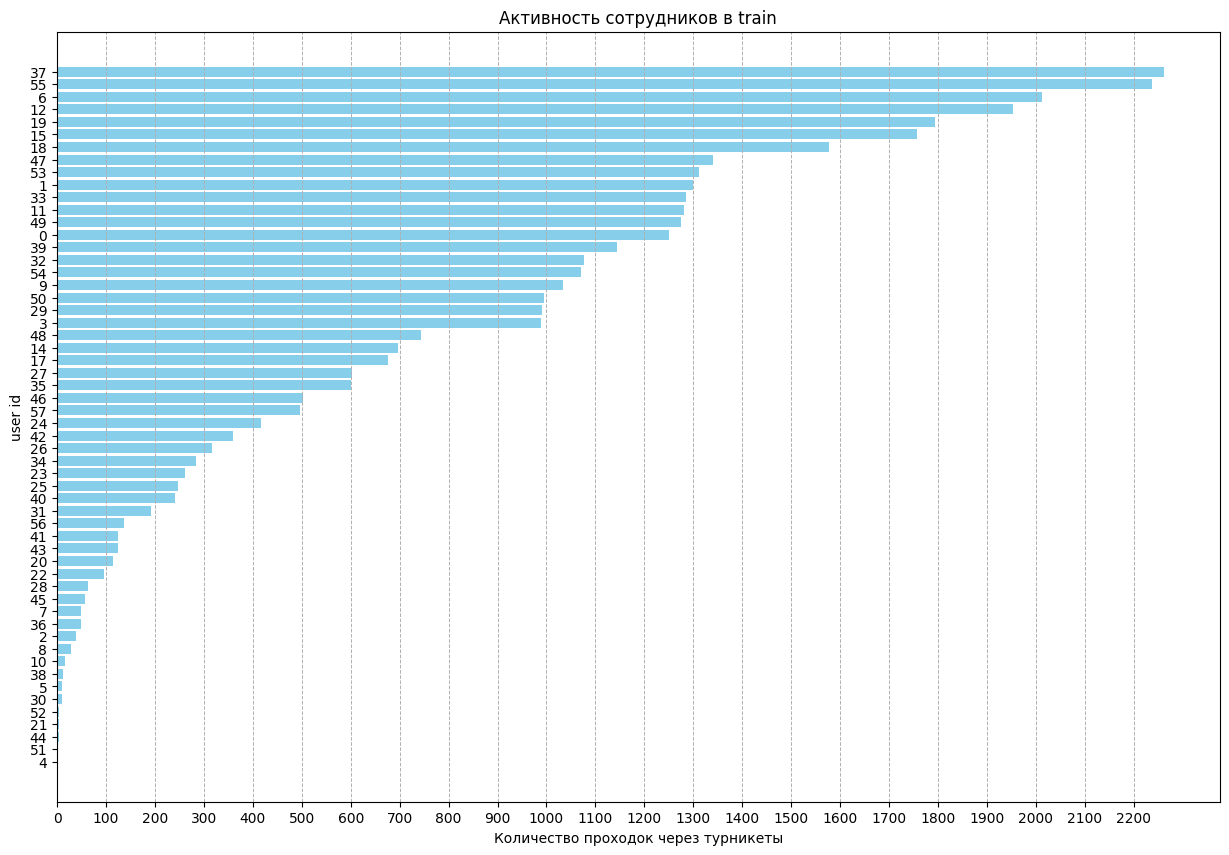

In [17]:
plt.figure(figsize=(15, 10))
plt.barh(count_user_id.index.astype(str), count_user_id['count'], color='skyblue')
plt.xlabel('Количество проходок через турникеты')
plt.ylabel('user id')
plt.title('Активность сотрудников в train')
plt.xticks(np.arange(0, 2210, 100))
plt.grid(axis='x', linestyle='--', linewidth=0.7)

Удалим неактивных сотрудников, количество проходов через турникеты которых менее 30. Поскольку это слишком маленькие категории для обучения (подбор гиперпараметров модели будет выполняться с помощью кроссвалидации), и, скорее всего, этих сотрудников нет в test.

In [18]:
delete_user_id = count_user_id[count_user_id['count'] < 30].index.to_list()
delete_user_id

[4, 51, 44, 21, 52, 30, 5, 38, 10, 8]

In [19]:
df_train = df_train[~df_train['user_id'].isin(delete_user_id)]
df_train.shape

(37420, 3)

In [20]:
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

Количество сотрудников в train: 46


In [21]:
print(f'Количество сотрудников в test: {len(df_test.user_word.unique())}')

Количество сотрудников в test: 34


In [22]:
# по условию сказано, что в тестовой выборке может быть не более 10% новых сотрудников
int(.1 * len(df_test.user_word.unique()))

3

In [23]:
# активность сотрудников в test
count_user_word = df_test.user_word.value_counts(ascending=True).to_frame()

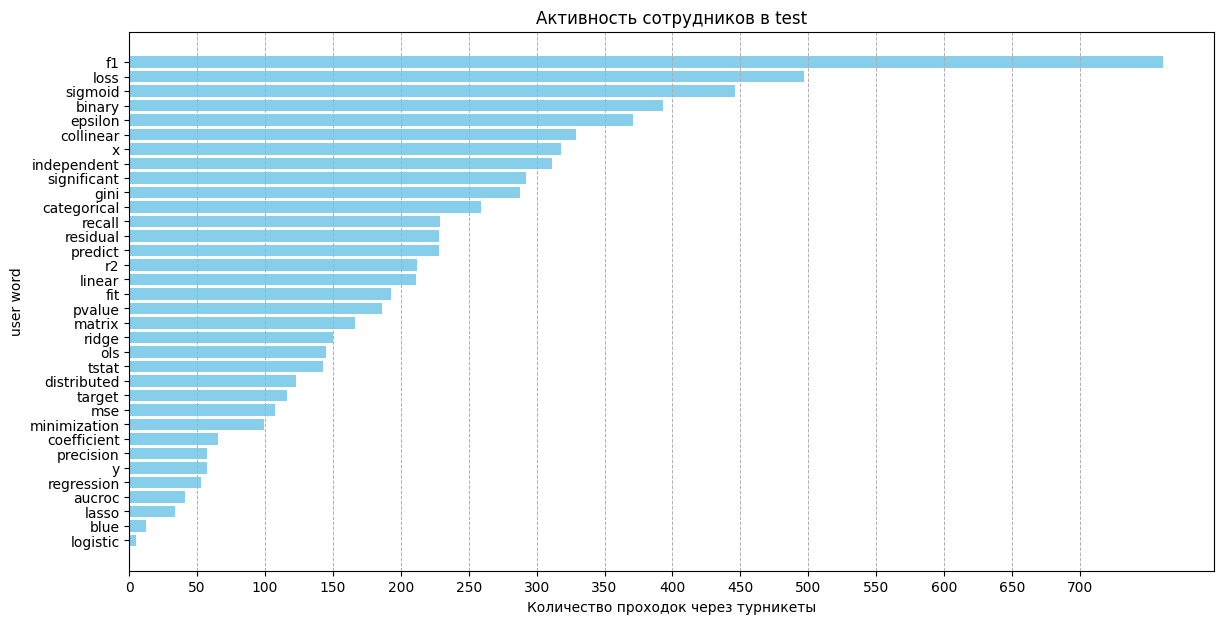

In [24]:
plt.figure(figsize=(14, 7))
plt.barh(count_user_word.index.astype(str), count_user_word['count'], color='skyblue')
plt.xlabel('Количество проходок через турникеты')
plt.ylabel('user word')
plt.title('Активность сотрудников в test')
plt.xticks(np.arange(0, 750, 50))
plt.grid(axis='x', linestyle='--', linewidth=0.7)

Турникеты

In [25]:
print(f'Количество турникетов в train: {len(df_train.gate_id.unique())}')
# частота использования турникетов в train
count_gate_id_train = df_train.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_train.T

Количество турникетов в train: 17


gate_id,14,0,16,1,8,-1,15,12,13,6,7,9,11,5,10,3,4
count,1,2,3,5,46,48,298,698,1201,1796,3022,3384,4081,4599,4757,5337,8142


In [26]:
print(f'Количество турникетов в test: {len(df_test.gate_id.unique())}')
# частота использования турникетов в test
count_gate_id_test = df_test.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_test.T

Количество турникетов в test: 16


gate_id,14,1,-1,2,8,15,12,6,13,7,11,9,5,3,10,4
count,1,2,2,4,18,102,132,294,345,540,762,780,860,909,915,1459


In [27]:
# id турникетов, которые есть в train, но нет в test
set(df_train.gate_id.unique()) - set(df_test.gate_id.unique())

{0, 16}

In [28]:
# id турникетов, которые есть в test, но нет в train
set(df_test.gate_id.unique()) - set(df_train.gate_id.unique())

{2}

Поскольку `gate_id` мы будем использовать в качестве признака, редкие категории (менее 5 записей) нужно удалить.

In [29]:
delete_gate_id = set(count_gate_id_train.query('count < 5').index) | set(count_gate_id_test.query('count < 5').index)
delete_gate_id

{-1, 0, 1, 2, 14, 16}

In [30]:
df_train = df_train.query('gate_id not in @delete_gate_id').reset_index(drop=True)
df_test = df_test.query('gate_id not in @delete_gate_id').reset_index(drop=True)

In [31]:
df_test.shape

(7116, 3)

Двойное срабатывание турникетов

In [32]:
def make_features_for_analysis(df):
    df = df.loc[:]
    # отсортируем датафреймы для удобства генерирования признаков
    df.sort_values(['user_id', 'ts'], inplace=True)
    df['date'] = df.ts.dt.normalize()
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # предыдущий турникет
    df['gate_id_lag_1'] = grouped_data['gate_id'].shift(1, fill_value=-100)
    # разница в секундах между текущей записью и предыдущей
    df['sec_btw_lag_1'] = df['total_seconds'] - grouped_data['total_seconds'].shift(1)
    df['sec_btw_lag_1'] = df['sec_btw_lag_1'].fillna(-1000).astype('int')

    return df

In [33]:
def plot_count_sec_btw_repeating_gate_id(df, max_interval_sec=100):
    # отфильтруем данные с повторным срабатыванием турникета
    df_repeating_gate_id = df.query('gate_id == gate_id_lag_1')
    # частота наблюдаемых промежутков времени между повторными срабатываниями турникетов
    sec_btw_repeating_gate_id = df_repeating_gate_id['sec_btw_lag_1'].value_counts().to_frame().sort_index()
    sec_btw_repeating_gate_id = sec_btw_repeating_gate_id[sec_btw_repeating_gate_id.index < max_interval_sec]

    plt.figure(figsize=(15, 3))
    plt.bar(sec_btw_repeating_gate_id.index.astype(str), sec_btw_repeating_gate_id['count'], color='skyblue')
    plt.xlabel('Количество секунд между повторными срабатываниями турникетов')
    plt.ylabel('Количество повторных срабатываний')
    plt.title('Повторное срабатывание турникетов');

In [34]:
def check_repeating_gate_id(df):
    # отфильтруем данные с повторным срабатыванием турникета
    df_repeating_gate_id = df.query('gate_id == gate_id_lag_1')
    result = pd.concat(
        [
            # умножаем на 2 для визуального сравнения с общим количеством срабатываний
            df_repeating_gate_id.query('sec_btw_lag_1 <= 3')['gate_id'].value_counts() * 2,
            df['gate_id'].value_counts()
        ],
        axis=1
    ).reset_index().fillna(0).astype(int)
    result.columns = ['gate_id', 'repeating', 'total']
    display(result)

In [35]:
df_train = make_features_for_analysis(df_train)

# временно переименуем колонку `user_word` на `user_id`
df_test = df_test.rename(columns={'user_word': 'user_id'})
df_test = make_features_for_analysis(df_test)

,gate_id,repeating,total
0,4,8110,8142
1,3,5276,5337
2,5,4592,4599
3,9,3384,3384
4,6,1792,1796
5,13,1196,1201
6,12,698,698
7,8,46,46
8,7,4,3022
9,10,0,4757


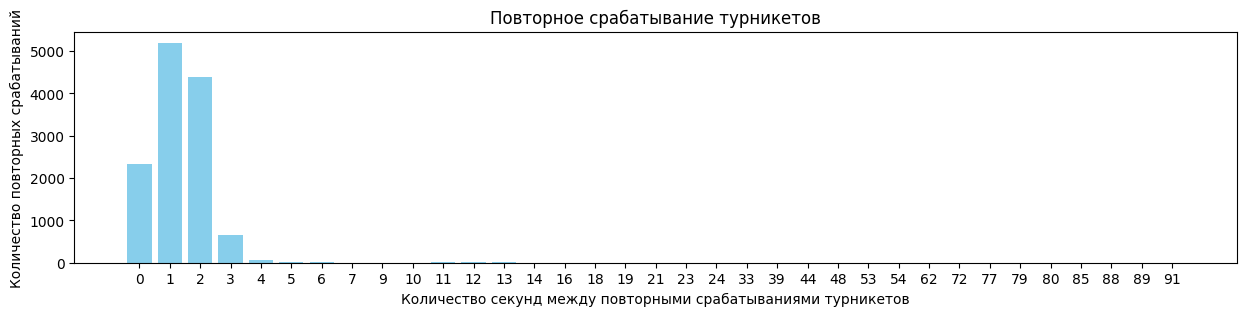

In [36]:
plot_count_sec_btw_repeating_gate_id(df_train)
check_repeating_gate_id(df_train)

,gate_id,repeating,total
0,4,1442,1459
1,3,888,909
2,5,834,860
3,9,780,780
4,13,344,345
5,6,292,294
6,12,132,132
7,8,18,18
8,7,2,540
9,10,0,915


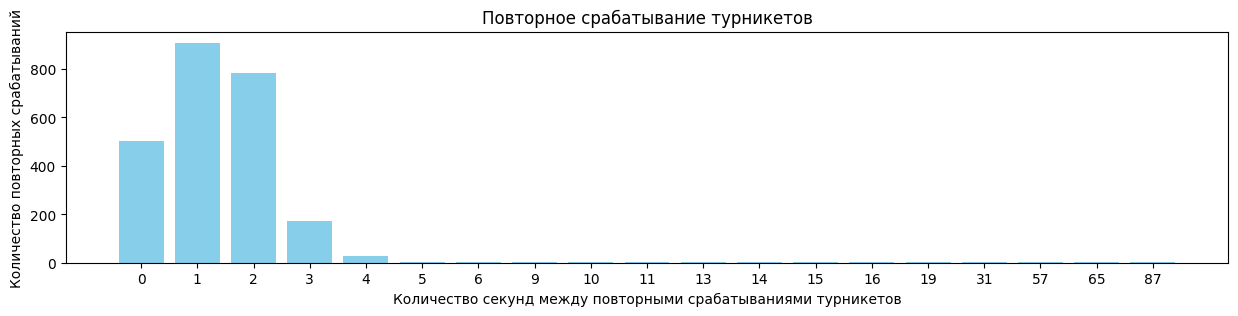

In [37]:
plot_count_sec_btw_repeating_gate_id(df_test)
check_repeating_gate_id(df_test)

Исходя из данных выше, полными дубликатами можно считать записи, если одновременно выполняются условия:

- `gate_id` совпадает с предыдущим,
- промежуток времени между срабатываниями не превышает 3 секунд,
- `gate_id` не равен 7.

In [38]:
df_train = df_train.query('not (gate_id == gate_id_lag_1 and sec_btw_lag_1 <= 3 and gate_id != 7)')
df_train.shape

(24814, 9)

In [39]:
df_test = df_test.query('not (gate_id == gate_id_lag_1 and sec_btw_lag_1 <= 3 and gate_id != 7)')
df_test.shape

(4751, 9)

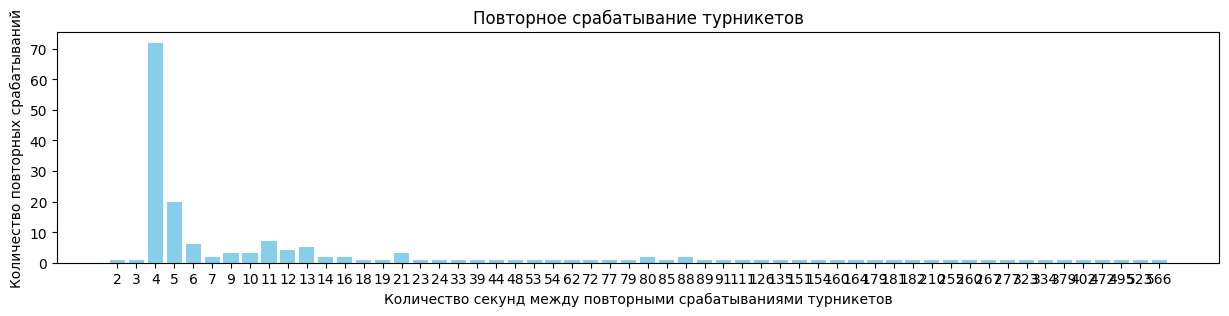

In [40]:
plot_count_sec_btw_repeating_gate_id(df_train, max_interval_sec=60*10)

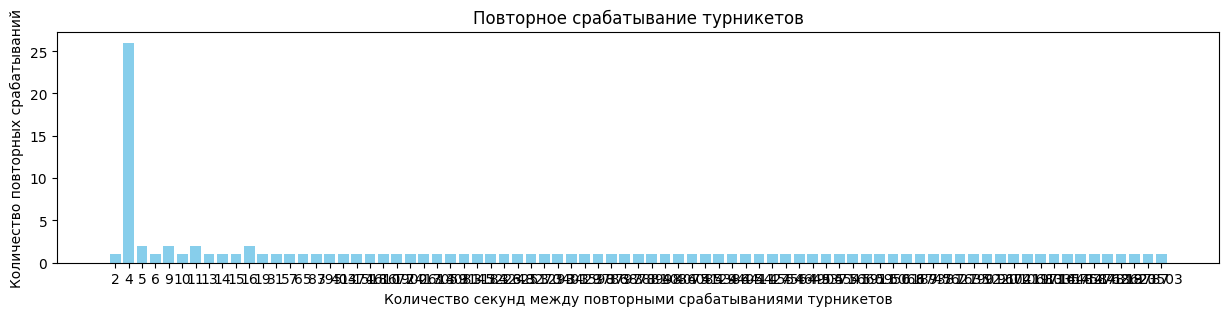

In [41]:
plot_count_sec_btw_repeating_gate_id(df_test, max_interval_sec=60*1000000)

# Генерирование признаков

In [42]:
def make_features(df):
    df = df.loc[:]
    # отсортируем датафрейм для удобства генерирования признаков
    # потом отсортируем только по дате
    df = df.sort_values(['user_id', 'ts']).reset_index(drop=True)
    # временные признаки
    df['date'] = df.ts.dt.normalize()
    df['day_of_month'] = df.ts.dt.day
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    df['week_number'] = df.ts.dt.isocalendar().week             # неделя начинается с пн. Вспомогательный признак
    df['day_of_week'] = df.ts.dt.dayofweek                      # 0 = пн.
    df['is_weekend'] = df.day_of_week >= 5
    df['time_of_day'] = np.select(
            condlist=[df['hour'] < 6, df['hour'] < 12, df['hour'] < 18],
            choicelist=['night', 'morning', 'afternoon'],
            default='evening',
    )       # время суток
    df['is_month_start'] = df['ts'].dt.is_month_start
    df['is_month_end'] = df['ts'].dt.is_month_end

    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # число проходов сотрудником ч/з турникуты в день
    df['pass_cnt_per_day'] = grouped_data['gate_id'].transform('size')
    # число проходов через конкретный турникет в конкретный день
    df['daily_gate_pass_count'] = df.groupby(['user_id', 'date', 'gate_id'])['gate_id'].transform('size')
    # вероятность прохода через конкретный турникет в конкретный день
    df['probability_gate_id'] = df['daily_gate_pass_count'] / df['pass_cnt_per_day']
    # количество сотрудников, вошедших в конкретный день в здание
    df['cnt_users_per_day'] = df.groupby('date')['user_id'].transform('nunique')
    # количество сотрудников, вошедших в конкретную неделю в здание
    df['cnt_users_per_week'] = df.groupby('week_number')['user_id'].transform('nunique')
    # индекс дневной явки сотрудника
    df['daily_attendance_index'] = df['cnt_users_per_day'] / df['cnt_users_per_week']
    # количество дней в конкретную неделю, в которые сотрудник заходил в здание
    df['cnt_days_per_week'] = df.groupby(['user_id', 'week_number'])['date'].transform('nunique')

    # время прихода на работу (количество минут от полуночи)
    df['entry_time'] = grouped_data['ts'].transform('min')
    df['entry_time'] = ((df['entry_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # время ухода с работы (количество минут от полуночи)
    df['exit_time'] = grouped_data['ts'].transform('max')
    df['exit_time'] = ((df['exit_time'] - df['date']).dt.total_seconds() // 60).astype('int')   # Вспомогательный признак
    # продолжительность рабочего времени в минутах
    df['working_time_per_day'] = df['exit_time'] - df['entry_time']
    # турникет, через который сотрудник зашел в здание в конкретный день
    df['entrance_gate_id'] = grouped_data['gate_id'].transform('first')
    # турникет, через который сотрудник вышел из здания в конкретный день
    df['exit_gate_id'] = grouped_data['gate_id'].transform('last')
    # продолжительность рабочего времени за неделю в минутах (working_time_per_week)
    df_working_time_per_week = df.groupby(['user_id', 'date'], as_index=False)[['week_number', 'working_time_per_day']].first()
    df_working_time_per_week = df_working_time_per_week.groupby(['user_id', 'week_number'], as_index=False)[['working_time_per_day']].sum()
    df_working_time_per_week = df_working_time_per_week.rename(columns={'working_time_per_day': 'working_time_per_week'})
    df = pd.merge(df, df_working_time_per_week, on=['user_id', 'week_number'], how='left')
    # индекс дневной нагрузки сотрудника - отношение минут работы за день к минутам работы за неделю
    df['daily_workload_index'] = df['working_time_per_day'] / df['working_time_per_week']
    # на случай, когда working_time_per_day = 0 и working_time_per_week = 0
    df['daily_workload_index'] = df['daily_workload_index'].fillna(0)

    for i in range(1, 6):
        # 5 предыдущих турникетов
        df[f'gate_id_lag_{i}'] = grouped_data['gate_id'].shift(i, fill_value=-100)
        # 5 последующих турникетов
        df[f'gate_id_{i}'] = grouped_data['gate_id'].shift(-i, fill_value=-200)
        # разница в секундах между текущей записью и пятью предыдущими
        df[f'sec_btw_lag_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(i)
        df[f'sec_btw_lag_{i}'] = df[f'sec_btw_lag_{i}'].fillna(-1000).astype('int')
        # разница в секундах между текущей записью и пятью следующими
        df[f'sec_btw_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(-i)
        df[f'sec_btw_{i}'] = df[f'sec_btw_{i}'].fillna(1000).astype('int')

    # метка gate_id, совпадающего с предыдущим, промежуток между срабатываниями менее 5 секунд
    df['repeat_gate_lt_5s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].lt(5)
    # -//- от 5 до 10 секунд
    df['repeat_gate_btw_5_10s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].between(5, 10, inclusive='left')
    # -//- от 10 до 15 секунд
    df['repeat_gate_btw_10_15s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].between(10, 15, inclusive='left')
    # -//- от 15 до 90 секунд
    df['repeat_gate_btw_15_90s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].between(15, 90, inclusive='left')
    # -//- от 90 секунд
    df['repeat_gate_ge_90s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].ge(90)
    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # количество повторных срабатываний турникетов для user_id в конкретный день, промежуток между срабатываниями менее 5 секунд
    df['cnt_repeat_gate_lt_5s'] = grouped_data['repeat_gate_lt_5s'].transform('sum')
    # -//- от 5 до 10 секунд
    df['cnt_repeat_gate_btw_5_10s'] = grouped_data['repeat_gate_btw_5_10s'].transform('sum')
    # -//- от 10 до 15 секунд
    df['cnt_repeat_gate_btw_10_15s'] = grouped_data['repeat_gate_btw_10_15s'].transform('sum')
    # -//- от 15 до 90 секунд
    df['cnt_repeat_gate_btw_15_90s'] = grouped_data['repeat_gate_btw_15_90s'].transform('sum')
    # -//- от 90 секунд
    df['cnt_repeat_gate_ge_90s'] = grouped_data['repeat_gate_ge_90s'].transform('sum')

    # маршрут – содержит информацию о соседних турникетах, через которые прошел сотрудник (направление не учитывается)
    df['route'] = df.apply(lambda row: str(sorted([row['gate_id_lag_1'], row['gate_id']])), axis=1)
    # если сотрудник пришел с улицы
    df.loc[df['route'].str.contains('-100'), 'route'] = 'not_route'

    # вспомогательный признак
    df['temp_sec_btw_lag_1'] = df['sec_btw_lag_1']
    # если сотрудник пришел с улицы
    df.loc[df['temp_sec_btw_lag_1'] < 0, 'temp_sec_btw_lag_1'] = 0
    # накопленное время нахождения в здании к моменту прохода через турникет в течение дня
    df['cumtime_per_day'] = df.groupby(['user_id', 'date'])['temp_sec_btw_lag_1'].cumsum()
    # накопленное время нахождения на конкретном маршруте в течение дня
    df['cumtime_at_route_per_day'] = df.groupby(['user_id', 'date', 'route'])['temp_sec_btw_lag_1'].cumsum()

    # самый часто используемый турникет за день
    df['most_frequent_gate_per_day'] = df.groupby(['user_id', 'date'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет за неделю
    df['most_frequent_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за день
    df['most_frequent_route_per_day'] = df.groupby(['user_id', 'date'])['route'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за неделю
    df['most_frequent_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform(lambda x: x.value_counts().idxmax())

    # удаление вспомогательных признаков
    # df = df.drop(columns=['week_number', 'exit_time', 'temp_sec_btw_lag_1'])

    return df

In [43]:
df_train = make_features(df_train)
df_train.head(3)

,user_id,ts,gate_id,date,hour,total_minutes,total_seconds,gate_id_lag_1,sec_btw_lag_1,day_of_month,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_lt_5s,repeat_gate_btw_5_10s,repeat_gate_btw_10_15s,repeat_gate_btw_15_90s,repeat_gate_ge_90s,cnt_repeat_gate_lt_5s,cnt_repeat_gate_btw_5_10s,cnt_repeat_gate_btw_10_15s,cnt_repeat_gate_btw_15_90s,cnt_repeat_gate_ge_90s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week
0,0,2022-07-29 10:30:17,3,2022-07-29,10,630,37817,-100,-1000,29,30,4,False,morning,False,False,8,2,0.25,23,23,1.00,1,630,1126,496,3,4,496,1.00,11,-10144,-100,6,-1000,-10171,-100,7,-1000,-13798,-100,3,-1000,-13869,-100,10,-1000,-13899,False,False,False,False,False,0,0,0,0,0,not_route,0,0,0,3,3,not_route,not_route
1,0,2022-07-29 13:19:21,11,2022-07-29,13,799,47961,3,10144,29,30,4,False,afternoon,False,False,8,2,0.25,23,23,1.00,1,630,1126,496,3,4,496,1.00,6,-27,-100,7,-1000,-3654,-100,3,-1000,-3725,-100,10,-1000,-3755,-100,11,-1000,-19588,False,False,False,False,False,0,0,0,0,0,"[3, 11]",10144,10144,10144,3,3,not_route,not_route
2,0,2022-07-29 13:19:48,6,2022-07-29,13,799,47988,11,27,29,30,4,False,afternoon,False,False,8,1,0.12,23,23,1.00,1,630,1126,496,3,4,496,1.00,7,-3627,3,3,10171,-3698,-100,10,-1000,-3728,-100,11,-1000,-19561,-100,4,-1000,-19589,False,False,False,False,False,0,0,0,0,0,"[6, 11]",27,10171,27,3,3,not_route,not_route


In [44]:
df_train.shape

(24814, 66)

In [45]:
df_test = make_features(df_test)
# df_test = df_test.rename(columns={'user_id': 'user_word'})
df_test.head(3)

,ts,gate_id,user_id,date,hour,total_minutes,total_seconds,gate_id_lag_1,sec_btw_lag_1,day_of_month,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_lt_5s,repeat_gate_btw_5_10s,repeat_gate_btw_10_15s,repeat_gate_btw_15_90s,repeat_gate_ge_90s,cnt_repeat_gate_lt_5s,cnt_repeat_gate_btw_5_10s,cnt_repeat_gate_btw_10_15s,cnt_repeat_gate_btw_15_90s,cnt_repeat_gate_ge_90s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week
0,2023-01-04 11:07:00,15,aucroc,2023-01-04,11,667,40020,-100,-1000,4,1,2,False,morning,False,False,7,2,0.29,21,27,0.78,2,667,1103,436,15,15,632,0.69,9,-164,-100,5,-1000,-174,-100,10,-1000,-192,-100,11,-1000,-25885,-100,4,-1000,-25910,False,False,False,False,False,0,0,0,0,0,not_route,0,0,0,15,15,not_route,not_route
1,2023-01-04 11:09:44,9,aucroc,2023-01-04,11,669,40184,15,164,4,1,2,False,morning,False,False,7,1,0.14,21,27,0.78,2,667,1103,436,15,15,632,0.69,5,-10,-100,10,-1000,-28,-100,11,-1000,-25721,-100,4,-1000,-25746,-100,15,-1000,-26000,False,False,False,False,False,0,0,0,0,0,"[9, 15]",164,164,164,15,15,not_route,not_route
2,2023-01-04 11:09:54,5,aucroc,2023-01-04,11,669,40194,9,10,4,1,2,False,morning,False,False,7,1,0.14,21,27,0.78,2,667,1103,436,15,15,632,0.69,10,-18,15,11,174,-25711,-100,4,-1000,-25736,-100,15,-1000,-25990,-100,-200,-1000,1000,False,False,False,False,False,0,0,0,0,0,"[5, 9]",10,174,10,15,15,not_route,not_route


In [46]:
df_test.shape

(4751, 66)

In [47]:
df_train['route'].value_counts()

route
[10, 11]     3427
[4, 11]      3310
not_route    2503
[3, 10]      2250
[5, 10]      1809
[3, 7]       1712
[5, 9]        996
[4, 7]        957
[4, 9]        667
[5, 7]        655
[7, 9]        625
[6, 11]       550
[10, 13]      519
[4, 5]        500
[3, 4]        490
[4, 10]       474
[12, 13]      381
[10, 10]      352
[5, 11]       273
[3, 11]       252
[6, 10]       241
[3, 6]        214
[6, 7]        207
[6, 9]        192
[9, 15]       145
[11, 12]      142
[5, 6]        126
[4, 15]       104
[11, 13]       87
[10, 12]       84
[11, 11]       59
[13, 13]       55
[4, 12]        38
[3, 13]        37
[4, 4]         35
[5, 13]        34
[3, 15]        33
[5, 5]         31
[7, 7]         25
[3, 9]         23
[4, 13]        22
[3, 3]         22
[4, 8]         16
[6, 13]        16
[15, 15]       16
[12, 12]       15
[5, 15]        13
[6, 12]        11
[3, 8]          9
[5, 12]         8
[5, 8]          8
[6, 6]          8
[3, 5]          7
[7, 15]         7
[7, 8]          5
[9, 

In [48]:
df_train.groupby('route')['temp_sec_btw_lag_1'].sum().sort_values(ascending=False)/3600

route
[10, 11]    10,891.64
[4, 10]      1,345.32
[5, 11]        832.22
[3, 11]        729.90
[6, 10]        713.69
[4, 7]         649.87
[10, 13]       570.95
[10, 10]       523.34
[4, 5]         434.09
[3, 4]         417.36
[12, 13]       188.58
[10, 12]       147.72
[3, 6]         147.48
[6, 7]         130.95
[11, 12]       127.54
[11, 13]       125.27
[5, 6]         125.13
[13, 13]        79.41
[5, 10]         65.19
[4, 12]         57.27
[3, 13]         53.93
[5, 13]         45.36
[11, 11]        42.58
[3, 10]         42.12
[4, 11]         30.58
[3, 7]          29.46
[7, 9]          26.26
[4, 13]         24.66
[15, 15]        19.97
[12, 12]        15.12
[6, 13]         14.72
[6, 12]         14.63
[5, 7]          12.31
[6, 11]         11.77
[9, 15]         10.67
[4, 15]          7.03
[7, 15]          6.48
[5, 9]           5.60
[3, 12]          5.11
[4, 9]           4.83
[7, 7]           3.88
[3, 15]          3.05
[9, 9]           2.96
[5, 12]          2.19
[5, 15]          2.13
[3, 

In [49]:
df_train.isna().sum().sum()

0

In [50]:
df_test.isna().sum().sum()

0

# Исследовательский анализ данных

In [51]:
week_counts_train = df_train['week_number'].value_counts().sort_index().reset_index()

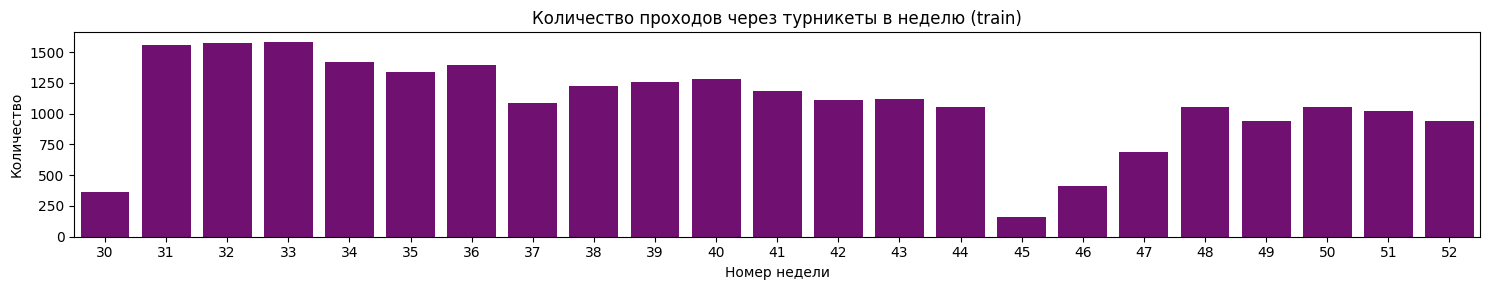

In [52]:
plt.figure(figsize=(15, 3))
sns.barplot(x='week_number', y='count', data=week_counts_train, color='purple')
plt.title('Количество проходов через турникеты в неделю (train)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [53]:
df_train.loc[df_train['week_number'] == 30, 'date'].nunique()

3

Мы видим, что 30 неделя - неполная. Поскольку при генерировании признаков мы использовали агрегацию по номеру недели, удалим данные за 30 неделю из тренировочной выборки.

In [54]:
df_train.shape

(24814, 66)

In [55]:
df_train = df_train.query('week_number > 30 and week_number != 45').reset_index(drop=True)
df_train.shape

(24288, 66)

In [56]:
df_train['user_id'].nunique()

46

In [57]:
week_counts_test = df_test['week_number'].value_counts().sort_index().reset_index()

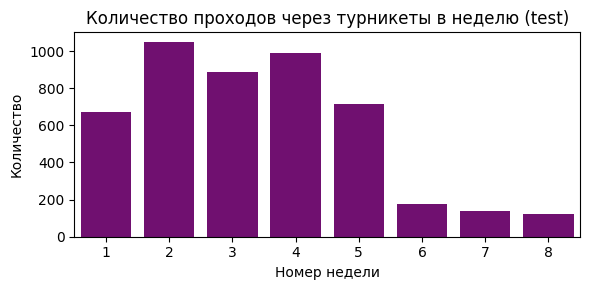

In [58]:
plt.figure(figsize=(6, 3))
sns.barplot(x='week_number', y='count', data=week_counts_test, color='purple')
plt.title('Количество проходов через турникеты в неделю (test)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [59]:
df_test.loc[df_test['week_number'] == 1, 'date'].nunique()

5

Удалим из тестовой выборки данные с 6 по 8 неделю, поскольку в этот период была маленькая активность.

In [60]:
df_test.shape

(4751, 66)

In [61]:
df_test = df_test.query('week_number < 6').reset_index(drop=True)
df_test.shape

(4315, 66)

In [62]:
df_test['user_id'].nunique()

34

In [63]:
# посмотрим распределение классов зависимой переменной
df_train['user_id'].value_counts(normalize=True)

user_id
37   0.06
55   0.06
12   0.05
6    0.05
15   0.05
19   0.05
18   0.04
47   0.04
1    0.04
33   0.03
11   0.03
0    0.03
49   0.03
53   0.03
9    0.03
39   0.03
32   0.03
54   0.03
50   0.03
3    0.03
29   0.03
48   0.02
14   0.02
17   0.02
35   0.02
57   0.01
27   0.01
46   0.01
24   0.01
42   0.01
26   0.01
34   0.01
40   0.01
23   0.01
25   0.01
31   0.00
43   0.00
41   0.00
56   0.00
20   0.00
22   0.00
28   0.00
45   0.00
7    0.00
36   0.00
2    0.00
Name: proportion, dtype: float64

In [64]:
df_train['user_id'].value_counts()

user_id
37    1509
55    1480
12    1303
6     1280
15    1144
19    1140
18     901
47     877
1      851
33     837
11     832
0      824
49     818
53     808
9      767
39     747
32     737
54     693
50     658
3      643
29     634
48     490
14     467
17     453
35     399
57     338
27     315
46     294
24     274
42     244
26     193
34     187
40     170
23     170
25     151
31     120
43      81
41      80
56      74
20      72
22      61
28      46
45      39
7       33
36      27
2       27
Name: count, dtype: int64

In [65]:
df_test['user_id'].value_counts(normalize=True)

user_id
f1             0.11
loss           0.07
sigmoid        0.07
binary         0.05
epsilon        0.05
significant    0.04
collinear      0.04
x              0.04
independent    0.04
residual       0.04
linear         0.03
gini           0.03
fit            0.03
predict        0.03
pvalue         0.03
recall         0.03
r2             0.03
categorical    0.03
ridge          0.02
tstat          0.02
ols            0.02
matrix         0.02
distributed    0.02
target         0.02
minimization   0.02
mse            0.01
coefficient    0.01
y              0.01
regression     0.01
aucroc         0.01
precision      0.01
lasso          0.00
blue           0.00
logistic       0.00
Name: proportion, dtype: float64

In [66]:
df_test['user_id'].value_counts()

user_id
f1              456
loss            309
sigmoid         281
binary          236
epsilon         220
significant     192
collinear       189
x               187
independent     175
residual        157
linear          142
gini            139
fit             134
predict         133
pvalue          129
recall          128
r2              126
categorical     124
ridge           106
tstat            99
ols              95
matrix           93
distributed      81
target           70
minimization     66
mse              63
coefficient      41
y                30
regression       30
aucroc           27
precision        26
lasso            20
blue              8
logistic          3
Name: count, dtype: int64

In [67]:
df_train = df_train.sort_values('ts').reset_index(drop=True)
df_test = df_test.sort_values('ts').reset_index(drop=True)

In [68]:
# удаление вспомогательных признаков
df_train = df_train.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)
df_test = df_test.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24288 entries, 0 to 24287
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       24288 non-null  int64  
 1   gate_id                       24288 non-null  int64  
 2   hour                          24288 non-null  int32  
 3   total_minutes                 24288 non-null  int32  
 4   total_seconds                 24288 non-null  int32  
 5   gate_id_lag_1                 24288 non-null  int64  
 6   sec_btw_lag_1                 24288 non-null  int32  
 7   day_of_month                  24288 non-null  int32  
 8   day_of_week                   24288 non-null  int32  
 9   is_weekend                    24288 non-null  bool   
 10  time_of_day                   24288 non-null  object 
 11  is_month_start                24288 non-null  bool   
 12  is_month_end                  24288 non-null  bool   
 13  p

In [70]:
df_train.columns

Index(['user_id', 'gate_id', 'hour', 'total_minutes', 'total_seconds',
       'gate_id_lag_1', 'sec_btw_lag_1', 'day_of_month', 'day_of_week',
       'is_weekend', 'time_of_day', 'is_month_start', 'is_month_end',
       'pass_cnt_per_day', 'daily_gate_pass_count', 'probability_gate_id',
       'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index',
       'cnt_days_per_week', 'entry_time', 'working_time_per_day',
       'entrance_gate_id', 'exit_gate_id', 'working_time_per_week',
       'daily_workload_index', 'gate_id_1', 'sec_btw_1', 'gate_id_lag_2',
       'gate_id_2', 'sec_btw_lag_2', 'sec_btw_2', 'gate_id_lag_3', 'gate_id_3',
       'sec_btw_lag_3', 'sec_btw_3', 'gate_id_lag_4', 'gate_id_4',
       'sec_btw_lag_4', 'sec_btw_4', 'gate_id_lag_5', 'gate_id_5',
       'sec_btw_lag_5', 'sec_btw_5', 'repeat_gate_lt_5s',
       'repeat_gate_btw_5_10s', 'repeat_gate_btw_10_15s',
       'repeat_gate_btw_15_90s', 'repeat_gate_ge_90s', 'cnt_repeat_gate_lt_5s',
       'cnt_repeat

In [71]:
categorical_features = [
       'user_id',
       'gate_id', 'hour', 'gate_id_lag_1',
       'day_of_month', 'day_of_week', 'is_weekend',
       'time_of_day', 'is_month_start', 'is_month_end',
       'entrance_gate_id', 'exit_gate_id', 'gate_id_1',
       'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3',
       'gate_id_3', 'gate_id_lag_4', 'gate_id_4',
       'gate_id_lag_5', 'gate_id_5', 'repeat_gate_lt_5s',
       'repeat_gate_btw_5_10s', 'repeat_gate_btw_10_15s', 'repeat_gate_btw_15_90s',
       'repeat_gate_ge_90s', 'route', 'most_frequent_gate_per_day',
       'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week'
]
df_train[categorical_features] = df_train[categorical_features].astype('category')
df_test[categorical_features] = df_test[categorical_features].astype('category')

In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24288 entries, 0 to 24287
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   user_id                       24288 non-null  category
 1   gate_id                       24288 non-null  category
 2   hour                          24288 non-null  category
 3   total_minutes                 24288 non-null  int32   
 4   total_seconds                 24288 non-null  int32   
 5   gate_id_lag_1                 24288 non-null  category
 6   sec_btw_lag_1                 24288 non-null  int32   
 7   day_of_month                  24288 non-null  category
 8   day_of_week                   24288 non-null  category
 9   is_weekend                    24288 non-null  category
 10  time_of_day                   24288 non-null  category
 11  is_month_start                24288 non-null  category
 12  is_month_end                  24288 non-null  

## Оценка важности признаков

### Корреляция между признаками

In [73]:
%%time
phik_overview = df_train.phik_matrix().round(2).sort_values('user_id', ascending=False)
phik_overview

interval columns not set, guessing: ['total_minutes', 'total_seconds', 'sec_btw_lag_1', 'pass_cnt_per_day', 'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week', 'entry_time', 'working_time_per_day', 'working_time_per_week', 'daily_workload_index', 'sec_btw_1', 'sec_btw_lag_2', 'sec_btw_2', 'sec_btw_lag_3', 'sec_btw_3', 'sec_btw_lag_4', 'sec_btw_4', 'sec_btw_lag_5', 'sec_btw_5', 'cnt_repeat_gate_lt_5s', 'cnt_repeat_gate_btw_5_10s', 'cnt_repeat_gate_btw_10_15s', 'cnt_repeat_gate_btw_15_90s', 'cnt_repeat_gate_ge_90s', 'cumtime_per_day', 'cumtime_at_route_per_day']


CPU times: total: 3.33 s
Wall time: 4.63 s


,user_id,gate_id,hour,total_minutes,total_seconds,gate_id_lag_1,sec_btw_lag_1,day_of_month,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_lt_5s,repeat_gate_btw_5_10s,repeat_gate_btw_10_15s,repeat_gate_btw_15_90s,repeat_gate_ge_90s,cnt_repeat_gate_lt_5s,cnt_repeat_gate_btw_5_10s,cnt_repeat_gate_btw_10_15s,cnt_repeat_gate_btw_15_90s,cnt_repeat_gate_ge_90s,route,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week
user_id,1.00,0.53,0.60,0.56,0.56,0.51,0.32,0.34,0.32,0.15,0.45,0.08,0.10,0.66,0.53,0.44,0.32,0.45,0.28,0.80,0.85,0.75,0.70,0.71,0.85,0.73,0.50,0.32,0.51,0.49,0.43,0.43,0.51,0.50,0.45,0.45,0.50,0.50,0.44,0.44,0.49,0.49,0.44,0.44,0.12,0.15,0.04,0.07,0.29,0.40,0.48,0.34,0.31,0.55,0.64,0.41,0.28,0.81,0.87,0.83,0.89
most_frequent_route_per_week,0.89,0.43,0.26,0.25,0.25,0.42,0.16,0.40,0.18,0.12,0.24,0.10,0.12,0.49,0.31,0.38,0.21,0.49,0.20,0.47,0.45,0.42,0.44,0.43,0.55,0.39,0.42,0.16,0.43,0.41,0.23,0.23,0.43,0.41,0.25,0.25,0.42,0.41,0.26,0.26,0.41,0.41,0.27,0.27,0.06,0.15,0.00,0.05,0.34,0.30,0.74,0.16,0.27,0.58,0.63,0.22,0.14,0.74,0.81,0.94,1.00
most_frequent_gate_per_week,0.87,0.44,0.26,0.21,0.21,0.40,0.10,0.28,0.10,0.07,0.19,0.05,0.05,0.32,0.21,0.18,0.15,0.29,0.16,0.29,0.44,0.31,0.55,0.54,0.42,0.23,0.40,0.10,0.40,0.38,0.15,0.15,0.40,0.38,0.16,0.16,0.39,0.38,0.18,0.18,0.37,0.37,0.18,0.18,0.06,0.06,0.01,0.02,0.14,0.20,0.21,0.15,0.10,0.29,0.60,0.14,0.10,0.90,1.00,0.78,0.81
working_time_per_week,0.85,0.14,0.38,0.37,0.37,0.14,0.11,0.30,0.13,0.11,0.17,0.13,0.05,0.30,0.28,0.19,0.18,0.39,0.19,0.73,0.70,0.70,0.24,0.35,1.00,0.78,0.15,0.11,0.16,0.16,0.17,0.17,0.16,0.17,0.20,0.20,0.17,0.17,0.21,0.21,0.16,0.16,0.24,0.24,0.05,0.08,0.03,0.02,0.06,0.14,0.19,0.23,0.12,0.19,0.26,0.34,0.22,0.30,0.42,0.52,0.55
entry_time,0.85,0.15,0.67,0.66,0.66,0.15,0.15,0.28,0.26,0.36,0.40,0.08,0.05,0.26,0.21,0.14,0.30,0.29,0.30,0.22,1.00,0.78,0.25,0.31,0.70,0.44,0.16,0.15,0.16,0.15,0.23,0.23,0.17,0.15,0.25,0.25,0.18,0.16,0.26,0.26,0.17,0.17,0.24,0.24,0.08,0.13,0.04,0.02,0.04,0.19,0.30,0.15,0.08,0.13,0.32,0.33,0.19,0.38,0.44,0.55,0.45
most_frequent_route_per_day,0.83,0.52,0.34,0.31,0.31,0.52,0.24,0.48,0.43,0.31,0.32,0.13,0.10,0.67,0.45,0.52,0.33,0.41,0.33,0.38,0.55,0.53,0.57,0.52,0.52,0.43,0.52,0.24,0.53,0.51,0.34,0.34,0.54,0.52,0.38,0.38,0.54,0.53,0.39,0.39,0.53,0.53,0.40,0.40,0.10,0.20,0.04,0.09,0.42,0.37,0.76,0.27,0.44,0.69,0.75,0.31,0.19,0.88,0.78,1.00,0.94
most_frequent_gate_per_day,0.81,0.51,0.23,0.19,0.19,0.48,0.14,0.33,0.30,0.33,0.20,0.08,0.07,0.46,0.32,0.32,0.35,0.21,0.34,0.22,0.38,0.33,0.67,0.58,0.30,0.28,0.46,0.14,0.48,0.45,0.20,0.20,0.48,0.45,0.21,0.21,0.47,0.45,0.22,0.22,0.45,0.45,0.22,0.22,0.06,0.04,0.04,0.05,0.18,0.20,0.20,0.30,0.21,0.37,0.69,0.16,0.14,1.00,0.90,0.88,0.74
cnt_days_per_week,0.80,0.16,0.14,0.09,0.09,0.11,0.04,0.38,0.21,0.34,0.08,0.15,0.08,0.20,0.13,0.15,0.24,0.40,0.25,1.00,0.22,0.22,0.25,0.21,0.73,0.84,0.12,0.04,0.12,0.12,0.06,0.06,0.12,0.12,0.08,0.08,0.12,0.12,0.09,0.09,0.12,0.12,0.10,0.10,0.02,0.02,0.00,0.00,0.07,0.12,0.13,0.10,0.06,0.17,0.21,0.07,0.04,0.22,0.29,0.38,0.47
working_time_per_day,0.75,0.12,0.40,0.43,0.43,0.12,0.23,0.34,0.27,0.36,0.26,0.16,0.07,0.39,0.31,0.19,0.30,0.23,0.28,0.22,0.78,1.00,0.19,0.41,0.70,0.62,0.14,0.23,0.14,0.15,0.32,0.32,0.15,0.16,0.36,0.36,0.16,0.17,0.38,0.38,0.17,0.17,0.39,0.39,0.07,0.10,0.03,0.02,0.05,0.16,0.25,0.25,0.11,0.21,0.25,0.76,0.35,0.33,0.31,0.53,0.42
daily_workload_index,0.73,0.11,0.14,0.16,0.16,0.10,0.09,0.38,0.38,

In [74]:
# отберем фичи, у которых корреляция с целевым признаком более 0.2
df_train = df_train[phik_overview[phik_overview['user_id'] > 0.2].index]

In [75]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(phik_overview, vmin=0, vmax=1, cmap='Purples', annot=True, linewidths=0.1, fmt='.2f')
# plt.suptitle('Матрица Phi_K-корреляций', y=0.92);

In [76]:
# %%time
# significance_overview = df_train.significance_matrix().fillna(0).round(1).sort_values('user_id', ascending=False)
# significance_overview

In [77]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(significance_overview, vmin=-5, vmax=5, cmap='Purples', annot=True, linewidths=0.1, fmt='.1f')
# plt.suptitle('Значимость коэффициентов', y=0.92);

# Построение моделей

## Разделение исходных данных на выборки

In [78]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24288 entries, 0 to 24287
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   user_id                       24288 non-null  category
 1   most_frequent_route_per_week  24288 non-null  category
 2   most_frequent_gate_per_week   24288 non-null  category
 3   working_time_per_week         24288 non-null  int32   
 4   entry_time                    24288 non-null  int32   
 5   most_frequent_route_per_day   24288 non-null  category
 6   most_frequent_gate_per_day    24288 non-null  category
 7   cnt_days_per_week             24288 non-null  int64   
 8   working_time_per_day          24288 non-null  int32   
 9   daily_workload_index          24288 non-null  float64 
 10  exit_gate_id                  24288 non-null  category
 11  entrance_gate_id              24288 non-null  category
 12  pass_cnt_per_day              24288 non-null  

In [79]:
y = df_train['user_id']
X = df_train.drop(['user_id'], axis=1)

In [80]:
categorical_columns = X.select_dtypes(include=['category']).columns.tolist()
print(categorical_columns)

['most_frequent_route_per_week', 'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_gate_per_day', 'exit_gate_id', 'entrance_gate_id', 'route', 'hour', 'gate_id', 'gate_id_lag_2', 'gate_id_lag_3', 'gate_id_lag_1', 'gate_id_3', 'gate_id_lag_4', 'gate_id_1', 'gate_id_4', 'gate_id_2', 'gate_id_5', 'gate_id_lag_5', 'time_of_day', 'day_of_month', 'day_of_week', 'repeat_gate_ge_90s']


In [81]:
len(categorical_columns)

23

In [82]:
numerical_columns = X.select_dtypes(exclude=['category']).columns.tolist()
print(numerical_columns)

['working_time_per_week', 'entry_time', 'cnt_days_per_week', 'working_time_per_day', 'daily_workload_index', 'pass_cnt_per_day', 'total_seconds', 'total_minutes', 'cnt_repeat_gate_ge_90s', 'daily_gate_pass_count', 'cnt_repeat_gate_btw_5_10s', 'cnt_users_per_week', 'sec_btw_lag_3', 'sec_btw_3', 'sec_btw_lag_4', 'probability_gate_id', 'sec_btw_5', 'sec_btw_lag_5', 'sec_btw_4', 'sec_btw_2', 'sec_btw_lag_2', 'cumtime_per_day', 'cnt_repeat_gate_lt_5s', 'cnt_repeat_gate_btw_10_15s', 'cnt_users_per_day', 'sec_btw_lag_1', 'sec_btw_1', 'cnt_repeat_gate_btw_15_90s', 'daily_attendance_index', 'cumtime_at_route_per_day']


In [83]:
len(numerical_columns)

30

In [84]:
X = X[categorical_columns + numerical_columns]

In [85]:
# формируем массив индексов категориальных признаков
categorical_features_indices = np.where(X.dtypes == 'category')[0]
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int64)

In [86]:
# выделение обучающей выборки (80 %) и тестовой (20 %)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y
)

In [87]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19430, 53), (4858, 53), (19430,), (4858,))

In [88]:
y_train.nunique()

46

In [89]:
y_test.nunique()

46

## CatBoostClassifier

### Подбор гиперпараметров

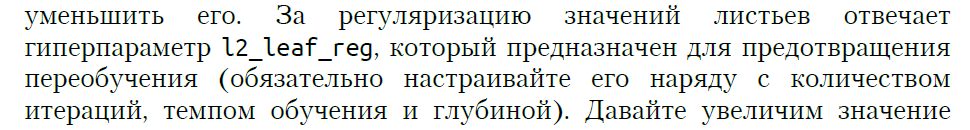

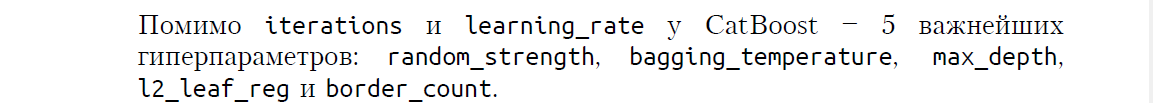

In [303]:
ctbst = CatBoostClassifier(
            n_estimators=200,
            thread_count=-1,
            random_state=RANDOM_STATE,
            cat_features=categorical_features_indices,
            loss_function='MultiClass',
            # eval_metric='TotalF1:average=Macro',
            task_type='GPU'

)

In [304]:
# задаем сетку значений гиперпараметров
param_grid = {'auto_class_weights': ['None', 'Balanced'],
        'learning_rate': [0.1, 0.05, 0.01]}

In [305]:
gs = GridSearchCV(ctbst,
        param_grid,
        cv=5,
        scoring='f1_macro',
        # n_jobs=-1,
        return_train_score=False)

In [306]:
%%time

# выполняем поиск по сетке
gs.fit(X_train, y_train)

0:	learn: 3.3251742	total: 101ms	remaining: 20.1s
1:	learn: 3.0097365	total: 218ms	remaining: 21.6s
2:	learn: 2.7875469	total: 301ms	remaining: 19.8s
3:	learn: 2.6098173	total: 383ms	remaining: 18.7s
4:	learn: 2.4392327	total: 462ms	remaining: 18s
5:	learn: 2.3356284	total: 536ms	remaining: 17.3s
6:	learn: 2.2248466	total: 625ms	remaining: 17.2s
7:	learn: 2.1131820	total: 707ms	remaining: 17s
8:	learn: 2.0196921	total: 774ms	remaining: 16.4s
9:	learn: 1.9387848	total: 840ms	remaining: 16s
10:	learn: 1.8455785	total: 923ms	remaining: 15.9s
11:	learn: 1.7621343	total: 1.01s	remaining: 15.8s
12:	learn: 1.6879119	total: 1.08s	remaining: 15.6s
13:	learn: 1.6234704	total: 1.16s	remaining: 15.4s
14:	learn: 1.5499805	total: 1.24s	remaining: 15.3s
15:	learn: 1.4989403	total: 1.32s	remaining: 15.2s
16:	learn: 1.4444376	total: 1.4s	remaining: 15s
17:	learn: 1.4063822	total: 1.48s	remaining: 15s
18:	learn: 1.3587961	total: 1.57s	remaining: 15s
19:	learn: 1.3192800	total: 1.65s	remaining: 14.9s
20:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E61C36D5A0>,
             param_grid={'auto_class_weights': ['None', 'Balanced'],
                         'learning_rate': [0.1, 0.05, 0.01]},
             scoring='f1_macro')

In [308]:
# смотрим наилучшие значения гиперпараметров
print("Наилучшие значения гиперпараметров: {}".format(gs.best_params_))
# смотрим наилучшее значение F1
print("Наилучшее значение F1: {:.3f}".format(gs.best_score_))

Наилучшие значения гиперпараметров: {'auto_class_weights': 'Balanced', 'learning_rate': 0.1}
Наилучшее значение F1: 0.973


In [314]:
# смотрим результаты по всем комбинациям значений гиперпараметров
cv_results = pd.DataFrame(gs.cv_results_)[['mean_test_score',
                                            'param_auto_class_weights',
                                            'param_learning_rate']]
cv_results = cv_results.sort_values(
    by='mean_test_score', ascending=False).reset_index(drop=True)
cv_results

,mean_test_score,param_auto_class_weights,param_learning_rate
0,0.97,Balanced,0.10
1,0.96,None,0.10
2,0.94,Balanced,0.05
3,0.92,None,0.05
4,0.71,Balanced,0.01
5,0.58,None,0.01


In [95]:
# создаем новый экземпляр класса CatBoostClassifier
ctbst2 = CatBoostClassifier(
            n_estimators=200,
            thread_count=-1,
            random_state=RANDOM_STATE,
            cat_features=categorical_features_indices,
            loss_function='MultiClass',
            learning_rate=0.1,
            auto_class_weights='Balanced',
            task_type='GPU',
            logging_level='Silent'
)

In [96]:
# задаем новое пространство поиска
param_distributions = {'max_depth': IntDistribution(6, 12),
                        'l2_leaf_reg': FloatDistribution(3.0, 60.0),
                        'border_count': IntDistribution(32, 128)}

In [97]:
# создаем экземпляр класса OptunaSearchCV
optuna_search = OptunaSearchCV(
                        ctbst2,
                        param_distributions,
                        scoring='f1_macro',
                        random_state=RANDOM_STATE,
                        n_trials=10,
                        verbose=1,
                        cv=5)

In [98]:
%%time
# выполняем оптимизацию
optuna_search.fit(X_train, y_train)

[I 2024-08-12 16:27:15,209] A new study created in memory with name: no-name-31172f1f-27bd-4587-9363-ace4f3b1e42f


0:	learn: 3.6124588	total: 288ms	remaining: 57.3s
1:	learn: 3.4317139	total: 559ms	remaining: 55.3s
2:	learn: 3.2822507	total: 824ms	remaining: 54.1s
3:	learn: 3.1477964	total: 1.1s	remaining: 54s
4:	learn: 2.9872236	total: 1.37s	remaining: 53.5s
5:	learn: 2.8475548	total: 1.62s	remaining: 52.4s
6:	learn: 2.7269835	total: 1.89s	remaining: 52.1s
7:	learn: 2.6223474	total: 2.16s	remaining: 51.8s
8:	learn: 2.5240505	total: 2.43s	remaining: 51.7s
9:	learn: 2.4355153	total: 2.72s	remaining: 51.6s
10:	learn: 2.3563567	total: 3.02s	remaining: 51.9s
11:	learn: 2.2853441	total: 3.31s	remaining: 51.9s
12:	learn: 2.2162854	total: 3.61s	remaining: 51.9s
13:	learn: 2.1561256	total: 3.9s	remaining: 51.8s
14:	learn: 2.0995945	total: 4.2s	remaining: 51.8s
15:	learn: 2.0469172	total: 4.49s	remaining: 51.6s
16:	learn: 1.9939320	total: 4.8s	remaining: 51.7s
17:	learn: 1.9483122	total: 5.13s	remaining: 51.9s
18:	learn: 1.9051759	total: 5.45s	remaining: 52s
19:	learn: 1.8645526	total: 5.75s	remaining: 51.7

[I 2024-08-12 16:32:33,706] Trial 0 finished with value: 0.929380185181641 and parameters: {'max_depth': 9, 'l2_leaf_reg': 50.46002584195271, 'border_count': 38}. Best is trial 0 with value: 0.929380185181641.


199:	learn: 0.2969807	total: 1m 23s	remaining: 0us
0:	learn: 3.4761805	total: 307ms	remaining: 1m 1s
1:	learn: 3.2351926	total: 604ms	remaining: 59.8s
2:	learn: 3.0210231	total: 925ms	remaining: 1m
3:	learn: 2.8415184	total: 1.25s	remaining: 1m 1s
4:	learn: 2.6905019	total: 1.56s	remaining: 1m
5:	learn: 2.5468911	total: 1.87s	remaining: 1m
6:	learn: 2.4387223	total: 2.19s	remaining: 1m
7:	learn: 2.3369242	total: 2.54s	remaining: 1m
8:	learn: 2.2505681	total: 2.89s	remaining: 1m 1s
9:	learn: 2.1660940	total: 3.21s	remaining: 1m 1s
10:	learn: 2.0859981	total: 3.52s	remaining: 1m
11:	learn: 2.0218722	total: 3.86s	remaining: 1m
12:	learn: 1.9484685	total: 4.18s	remaining: 1m
13:	learn: 1.8893191	total: 4.51s	remaining: 59.9s
14:	learn: 1.8401083	total: 4.85s	remaining: 59.8s
15:	learn: 1.7908811	total: 5.19s	remaining: 59.7s
16:	learn: 1.7414537	total: 5.51s	remaining: 59.3s
17:	learn: 1.6955596	total: 5.82s	remaining: 58.8s
18:	learn: 1.6519622	total: 6.13s	remaining: 58.4s
19:	learn: 1.6

[I 2024-08-12 16:37:09,997] Trial 1 finished with value: 0.9482129114076967 and parameters: {'max_depth': 8, 'l2_leaf_reg': 30.65566999962991, 'border_count': 60}. Best is trial 1 with value: 0.9482129114076967.


199:	learn: 0.2269606	total: 54.2s	remaining: 0us
0:	learn: 3.3265484	total: 218ms	remaining: 43.3s
1:	learn: 3.0854777	total: 434ms	remaining: 43s
2:	learn: 2.8637254	total: 662ms	remaining: 43.5s
3:	learn: 2.6893093	total: 883ms	remaining: 43.2s
4:	learn: 2.5659834	total: 1.11s	remaining: 43.3s
5:	learn: 2.4390742	total: 1.33s	remaining: 43.1s
6:	learn: 2.3170275	total: 1.57s	remaining: 43.2s
7:	learn: 2.2111799	total: 1.78s	remaining: 42.8s
8:	learn: 2.0918494	total: 2s	remaining: 42.5s
9:	learn: 1.9802350	total: 2.2s	remaining: 41.8s
10:	learn: 1.8980433	total: 2.42s	remaining: 41.7s
11:	learn: 1.8192021	total: 2.65s	remaining: 41.6s
12:	learn: 1.7499139	total: 2.86s	remaining: 41.2s
13:	learn: 1.6726054	total: 3.11s	remaining: 41.3s
14:	learn: 1.6209244	total: 3.3s	remaining: 40.8s
15:	learn: 1.5645296	total: 3.52s	remaining: 40.5s
16:	learn: 1.5163113	total: 3.75s	remaining: 40.3s
17:	learn: 1.4687971	total: 3.97s	remaining: 40.1s
18:	learn: 1.4264401	total: 4.19s	remaining: 39.9

[I 2024-08-12 16:40:30,102] Trial 2 finished with value: 0.9652779645003149 and parameters: {'max_depth': 7, 'l2_leaf_reg': 12.504569764279058, 'border_count': 49}. Best is trial 2 with value: 0.9652779645003149.


199:	learn: 0.1578384	total: 39.9s	remaining: 0us
0:	learn: 3.4182670	total: 318ms	remaining: 1m 3s
1:	learn: 3.1681674	total: 631ms	remaining: 1m 2s
2:	learn: 2.9326734	total: 968ms	remaining: 1m 3s
3:	learn: 2.7482549	total: 1.31s	remaining: 1m 4s
4:	learn: 2.5902518	total: 1.65s	remaining: 1m 4s
5:	learn: 2.4680996	total: 1.96s	remaining: 1m 3s
6:	learn: 2.3391433	total: 2.29s	remaining: 1m 3s
7:	learn: 2.2289284	total: 2.66s	remaining: 1m 3s
8:	learn: 2.1361587	total: 3.02s	remaining: 1m 4s
9:	learn: 2.0518772	total: 3.37s	remaining: 1m 4s
10:	learn: 1.9750255	total: 3.7s	remaining: 1m 3s
11:	learn: 1.9048496	total: 4.03s	remaining: 1m 3s
12:	learn: 1.8430066	total: 4.38s	remaining: 1m 3s
13:	learn: 1.7767499	total: 4.73s	remaining: 1m 2s
14:	learn: 1.7243252	total: 5.09s	remaining: 1m 2s
15:	learn: 1.6701683	total: 5.41s	remaining: 1m 2s
16:	learn: 1.6125589	total: 5.73s	remaining: 1m 1s
17:	learn: 1.5677183	total: 6.07s	remaining: 1m 1s
18:	learn: 1.5204390	total: 6.38s	remaining

[I 2024-08-12 16:45:15,275] Trial 3 finished with value: 0.9532167925278318 and parameters: {'max_depth': 8, 'l2_leaf_reg': 22.896856803047417, 'border_count': 128}. Best is trial 2 with value: 0.9652779645003149.


199:	learn: 0.2166233	total: 55.6s	remaining: 0us
0:	learn: 3.3959816	total: 477ms	remaining: 1m 34s
1:	learn: 3.1351884	total: 955ms	remaining: 1m 34s
2:	learn: 2.8528994	total: 1.43s	remaining: 1m 34s
3:	learn: 2.6300591	total: 1.9s	remaining: 1m 32s
4:	learn: 2.4519327	total: 2.37s	remaining: 1m 32s
5:	learn: 2.3048597	total: 2.84s	remaining: 1m 31s
6:	learn: 2.1801801	total: 3.34s	remaining: 1m 32s
7:	learn: 2.0681412	total: 3.83s	remaining: 1m 31s
8:	learn: 1.9669710	total: 4.33s	remaining: 1m 32s
9:	learn: 1.8794793	total: 4.84s	remaining: 1m 31s
10:	learn: 1.7951261	total: 5.32s	remaining: 1m 31s
11:	learn: 1.7279759	total: 5.84s	remaining: 1m 31s
12:	learn: 1.6587438	total: 6.31s	remaining: 1m 30s
13:	learn: 1.5905739	total: 6.8s	remaining: 1m 30s
14:	learn: 1.5366949	total: 7.33s	remaining: 1m 30s
15:	learn: 1.4854932	total: 7.86s	remaining: 1m 30s
16:	learn: 1.4277726	total: 8.34s	remaining: 1m 29s
17:	learn: 1.3786267	total: 8.81s	remaining: 1m 29s
18:	learn: 1.3332020	total

[I 2024-08-12 16:52:15,761] Trial 4 finished with value: 0.9764877374461125 and parameters: {'max_depth': 9, 'l2_leaf_reg': 16.51239092824843, 'border_count': 69}. Best is trial 4 with value: 0.9764877374461125.


199:	learn: 0.1204147	total: 1m 24s	remaining: 0us
0:	learn: 3.6137253	total: 502ms	remaining: 1m 39s
1:	learn: 3.4358544	total: 1s	remaining: 1m 39s
2:	learn: 3.2888903	total: 1.49s	remaining: 1m 38s
3:	learn: 3.1104485	total: 2s	remaining: 1m 38s
4:	learn: 2.9618603	total: 2.51s	remaining: 1m 37s
5:	learn: 2.8335643	total: 3s	remaining: 1m 36s
6:	learn: 2.7149172	total: 3.47s	remaining: 1m 35s
7:	learn: 2.6176177	total: 4.01s	remaining: 1m 36s
8:	learn: 2.5214435	total: 4.53s	remaining: 1m 36s
9:	learn: 2.4330660	total: 5.04s	remaining: 1m 35s
10:	learn: 2.3481964	total: 5.54s	remaining: 1m 35s
11:	learn: 2.2785539	total: 6.07s	remaining: 1m 35s
12:	learn: 2.2109463	total: 6.63s	remaining: 1m 35s
13:	learn: 2.1512146	total: 7.17s	remaining: 1m 35s
14:	learn: 2.0945700	total: 7.7s	remaining: 1m 35s
15:	learn: 2.0436150	total: 8.23s	remaining: 1m 34s
16:	learn: 1.9967594	total: 8.78s	remaining: 1m 34s
17:	learn: 1.9505447	total: 9.32s	remaining: 1m 34s
18:	learn: 1.9053499	total: 9.84s

[I 2024-08-12 16:59:56,299] Trial 5 finished with value: 0.9292447222982458 and parameters: {'max_depth': 9, 'l2_leaf_reg': 51.847172012034285, 'border_count': 126}. Best is trial 4 with value: 0.9764877374461125.


199:	learn: 0.3012793	total: 1m 30s	remaining: 0us
0:	learn: 3.6030929	total: 431ms	remaining: 1m 25s
1:	learn: 3.4281513	total: 916ms	remaining: 1m 30s
2:	learn: 3.2831394	total: 1.39s	remaining: 1m 31s
3:	learn: 3.1542657	total: 1.88s	remaining: 1m 32s
4:	learn: 3.0373626	total: 2.39s	remaining: 1m 33s
5:	learn: 2.9092969	total: 2.9s	remaining: 1m 33s
6:	learn: 2.7842526	total: 3.36s	remaining: 1m 32s
7:	learn: 2.6787428	total: 3.84s	remaining: 1m 32s
8:	learn: 2.5829861	total: 4.33s	remaining: 1m 31s
9:	learn: 2.4949275	total: 4.82s	remaining: 1m 31s
10:	learn: 2.4077733	total: 5.29s	remaining: 1m 30s
11:	learn: 2.3363729	total: 5.8s	remaining: 1m 30s
12:	learn: 2.2677783	total: 6.3s	remaining: 1m 30s
13:	learn: 2.2058947	total: 6.8s	remaining: 1m 30s
14:	learn: 2.1482811	total: 7.32s	remaining: 1m 30s
15:	learn: 2.0964176	total: 7.83s	remaining: 1m 30s
16:	learn: 2.0485394	total: 8.37s	remaining: 1m 30s
17:	learn: 2.0030013	total: 8.95s	remaining: 1m 30s
18:	learn: 1.9599516	total:

[I 2024-08-12 17:07:19,942] Trial 6 finished with value: 0.9239915004407748 and parameters: {'max_depth': 9, 'l2_leaf_reg': 57.28566455133301, 'border_count': 76}. Best is trial 4 with value: 0.9764877374461125.


199:	learn: 0.3155883	total: 1m 27s	remaining: 0us
0:	learn: 3.6556607	total: 2.17s	remaining: 7m 11s
1:	learn: 3.5171157	total: 4.43s	remaining: 7m 18s
2:	learn: 3.3732498	total: 6.59s	remaining: 7m 12s
3:	learn: 3.2602771	total: 8.77s	remaining: 7m 9s
4:	learn: 3.1660938	total: 11.1s	remaining: 7m 12s
5:	learn: 3.0695687	total: 13.3s	remaining: 7m 10s
6:	learn: 2.9906562	total: 15.7s	remaining: 7m 11s
7:	learn: 2.9062503	total: 17.9s	remaining: 7m 8s
8:	learn: 2.8146970	total: 20.1s	remaining: 7m 7s
9:	learn: 2.7312207	total: 22.4s	remaining: 7m 5s
10:	learn: 2.6563476	total: 24.7s	remaining: 7m 4s
11:	learn: 2.5863536	total: 27s	remaining: 7m 3s
12:	learn: 2.5228865	total: 29.4s	remaining: 7m 2s
13:	learn: 2.4615446	total: 31.7s	remaining: 7m 1s
14:	learn: 2.4039010	total: 34.1s	remaining: 7m
15:	learn: 2.3497285	total: 36.5s	remaining: 7m
16:	learn: 2.2987005	total: 38.9s	remaining: 6m 59s
17:	learn: 2.2512278	total: 41.4s	remaining: 6m 58s
18:	learn: 2.2061221	total: 43.8s	remaini

[I 2024-08-12 17:44:06,840] Trial 7 finished with value: 0.9326474671281642 and parameters: {'max_depth': 12, 'l2_leaf_reg': 53.409545185319764, 'border_count': 40}. Best is trial 4 with value: 0.9764877374461125.


0:	learn: 3.6051715	total: 491ms	remaining: 1m 37s
1:	learn: 3.4225434	total: 983ms	remaining: 1m 37s
2:	learn: 3.2600156	total: 1.48s	remaining: 1m 36s
3:	learn: 3.1191765	total: 1.97s	remaining: 1m 36s
4:	learn: 2.9625136	total: 2.46s	remaining: 1m 36s
5:	learn: 2.8258364	total: 2.93s	remaining: 1m 34s
6:	learn: 2.7042986	total: 3.4s	remaining: 1m 33s
7:	learn: 2.6029883	total: 3.93s	remaining: 1m 34s
8:	learn: 2.5029621	total: 4.43s	remaining: 1m 33s
9:	learn: 2.4122278	total: 4.93s	remaining: 1m 33s
10:	learn: 2.3240776	total: 5.42s	remaining: 1m 33s
11:	learn: 2.2523329	total: 5.94s	remaining: 1m 33s
12:	learn: 2.1832826	total: 6.48s	remaining: 1m 33s
13:	learn: 2.1211772	total: 7s	remaining: 1m 32s
14:	learn: 2.0634601	total: 7.52s	remaining: 1m 32s
15:	learn: 2.0120100	total: 8.05s	remaining: 1m 32s
16:	learn: 1.9636051	total: 8.58s	remaining: 1m 32s
17:	learn: 1.9154006	total: 9.1s	remaining: 1m 31s
18:	learn: 1.8738530	total: 9.65s	remaining: 1m 31s
19:	learn: 1.8323081	total:

[I 2024-08-12 17:51:35,616] Trial 8 finished with value: 0.9305081453889985 and parameters: {'max_depth': 9, 'l2_leaf_reg': 49.090694178394564, 'border_count': 112}. Best is trial 4 with value: 0.9764877374461125.


199:	learn: 0.3072228	total: 1m 28s	remaining: 0us
0:	learn: 3.2510376	total: 489ms	remaining: 1m 37s
1:	learn: 2.9293124	total: 939ms	remaining: 1m 32s
2:	learn: 2.6915290	total: 1.47s	remaining: 1m 36s
3:	learn: 2.4994713	total: 1.99s	remaining: 1m 37s
4:	learn: 2.3395784	total: 2.54s	remaining: 1m 39s
5:	learn: 2.2102175	total: 3.06s	remaining: 1m 38s
6:	learn: 2.0698766	total: 3.56s	remaining: 1m 38s
7:	learn: 1.9361798	total: 4.09s	remaining: 1m 38s
8:	learn: 1.8205453	total: 4.61s	remaining: 1m 37s
9:	learn: 1.7230198	total: 5.12s	remaining: 1m 37s
10:	learn: 1.6388337	total: 5.59s	remaining: 1m 36s
11:	learn: 1.5439927	total: 6.05s	remaining: 1m 34s
12:	learn: 1.4687843	total: 6.51s	remaining: 1m 33s
13:	learn: 1.3948757	total: 7.07s	remaining: 1m 33s
14:	learn: 1.3310185	total: 7.61s	remaining: 1m 33s
15:	learn: 1.2693636	total: 8.15s	remaining: 1m 33s
16:	learn: 1.2126296	total: 8.66s	remaining: 1m 33s
17:	learn: 1.1619404	total: 9.15s	remaining: 1m 32s
18:	learn: 1.1172978	to

[I 2024-08-12 17:58:44,366] Trial 9 finished with value: 0.9861050863314358 and parameters: {'max_depth': 9, 'l2_leaf_reg': 8.70495598398662, 'border_count': 99}. Best is trial 9 with value: 0.9861050863314358.


199:	learn: 0.0824867	total: 1m 25s	remaining: 0us
0:	learn: 3.2028701	total: 512ms	remaining: 1m 41s
1:	learn: 2.8500551	total: 1.05s	remaining: 1m 44s
2:	learn: 2.5264444	total: 1.56s	remaining: 1m 42s
3:	learn: 2.3171303	total: 2.1s	remaining: 1m 42s
4:	learn: 2.1530158	total: 2.61s	remaining: 1m 41s
5:	learn: 2.0064136	total: 3.14s	remaining: 1m 41s
6:	learn: 1.8799250	total: 3.68s	remaining: 1m 41s
7:	learn: 1.7738402	total: 4.19s	remaining: 1m 40s
8:	learn: 1.6854603	total: 4.7s	remaining: 1m 39s
9:	learn: 1.5849152	total: 5.24s	remaining: 1m 39s
10:	learn: 1.5006143	total: 5.76s	remaining: 1m 38s
11:	learn: 1.4199955	total: 6.3s	remaining: 1m 38s
12:	learn: 1.3457392	total: 6.87s	remaining: 1m 38s
13:	learn: 1.2798375	total: 7.41s	remaining: 1m 38s
14:	learn: 1.2236885	total: 7.95s	remaining: 1m 38s
15:	learn: 1.1685500	total: 8.43s	remaining: 1m 36s
16:	learn: 1.1268023	total: 8.93s	remaining: 1m 36s
17:	learn: 1.0802897	total: 9.37s	remaining: 1m 34s
18:	learn: 1.0316241	total

OptunaSearchCV(cv=5,
               estimator=<catboost.core.CatBoostClassifier object at 0x000001952C9BE920>,
               n_jobs=1,
               param_distributions={'border_count': IntDistribution(high=128, log=False, low=32, step=1),
                                    'l2_leaf_reg': FloatDistribution(high=60.0, log=False, low=3.0, step=None),
                                    'max_depth': IntDistribution(high=12, log=False, low=6, step=1)},
               random_state=42, scoring='f1_macro', verbose=1)

In [99]:
# печатаем наилучшие значения гиперпараметров
print("Наилучшие значения гиперпараметров: {}".format(
optuna_search.best_params_))

Наилучшие значения гиперпараметров: {'max_depth': 9, 'l2_leaf_reg': 8.70495598398662, 'border_count': 99}


In [100]:
print("Наилучшее значение f1_macro: {:.3f}".format(
np.abs(optuna_search.best_score_)))

Наилучшее значение f1_macro: 0.986


### Проверка качества на тестовой выборке

In [101]:
# смотрим значение f1_macro на тестовой выборке
print("f1_macro на тестовой выборке: {:.3f}".format(
f1_score(y_test, optuna_search.predict(X_test), average='macro')))

f1_macro на тестовой выборке: 0.996


In [102]:
f1_score(y_train, optuna_search.predict(X_train), average='macro')

0.9988157436405081

In [106]:
# записываем оптимальные значения гиперпараметров
opt_params = optuna_search.best_params_
opt_params

{'max_depth': 9, 'l2_leaf_reg': 8.70495598398662, 'border_count': 99}

In [107]:
# модифицируем оптимальные значения гиперпараметров
opt_params.update({'n_estimators': 250})
opt_params

{'max_depth': 9,
 'l2_leaf_reg': 8.70495598398662,
 'border_count': 99,
 'n_estimators': 250}

In [108]:
ctbst2.get_params()

{'learning_rate': 0.1,
 'loss_function': 'MultiClass',
 'auto_class_weights': 'Balanced',
 'task_type': 'GPU',
 'n_estimators': 200,
 'random_state': 42,
 'cat_features': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22], dtype=int64)}

In [109]:
# присваиваем итоговому конвейеру оптимальные
# значения гиперпараметров
ctbst2.set_params(**opt_params)

In [110]:
ctbst2.get_params()

{'learning_rate': 0.1,
 'loss_function': 'MultiClass',
 'auto_class_weights': 'Balanced',
 'task_type': 'GPU',
 'n_estimators': 250,
 'random_state': 42,
 'cat_features': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22], dtype=int64),
 'max_depth': 9,
 'l2_leaf_reg': 8.70495598398662,
 'border_count': 99}

In [161]:
params_only_train = {'learning_rate': 0.1,
 'loss_function': 'MultiClass',
 'auto_class_weights': 'Balanced',
 'task_type': 'GPU',
 'n_estimators': 200,
 'random_state': 42,
 'cat_features': categorical_features_indices,
 'max_depth': 9,
 'l2_leaf_reg': 8.70495598398662,
 'border_count': 99,
 'logging_level': 'Silent'}

In [162]:
ctbst_only_train = CatBoostClassifier(**params_only_train)

In [163]:
%%time

ctbst_only_train.fit(X_train, y_train)

CPU times: total: 1min 41s
Wall time: 46.2 s


In [164]:
print("f1_macro на тестовой выборке: {:.3f}".format(
f1_score(y_test, optuna_search.predict(X_test), average='macro')))

f1_macro на тестовой выборке: 0.996


In [175]:
params_all = {'learning_rate': 0.1,
 'loss_function': 'MultiClass',
 'auto_class_weights': 'Balanced',
 'task_type': 'GPU',
 'n_estimators': 200,
 'random_state': 42,
 'cat_features': categorical_features_indices,
 'max_depth': 9,
 'l2_leaf_reg': 8.70495598398662,
 'border_count': 99,
 'logging_level': 'Silent'}

In [176]:
ctbst_all = CatBoostClassifier(**params_all)

In [177]:
%%time

ctbst_all.fit(X, y)

CPU times: total: 1min 45s
Wall time: 49.2 s


Обучимся на всей тренировочной выборке

In [111]:
%%time
# обучаем итоговый конвейер с оптимальными значениями
# гиперпараметров на всех исторических данных
ctbst2.fit(X, y)

0:	learn: 3.0261700	total: 363ms	remaining: 1m 30s
1:	learn: 2.6968501	total: 634ms	remaining: 1m 18s
2:	learn: 2.4554825	total: 914ms	remaining: 1m 15s
3:	learn: 2.2623255	total: 1.21s	remaining: 1m 14s
4:	learn: 2.1015663	total: 1.52s	remaining: 1m 14s
5:	learn: 1.9530275	total: 1.84s	remaining: 1m 14s
6:	learn: 1.8207464	total: 2.14s	remaining: 1m 14s
7:	learn: 1.6802065	total: 2.49s	remaining: 1m 15s
8:	learn: 1.5668751	total: 2.81s	remaining: 1m 15s
9:	learn: 1.4816412	total: 3.11s	remaining: 1m 14s
10:	learn: 1.3844996	total: 3.4s	remaining: 1m 13s
11:	learn: 1.3181921	total: 3.7s	remaining: 1m 13s
12:	learn: 1.2429944	total: 3.99s	remaining: 1m 12s
13:	learn: 1.1679906	total: 4.26s	remaining: 1m 11s
14:	learn: 1.1075445	total: 4.55s	remaining: 1m 11s
15:	learn: 1.0543344	total: 4.87s	remaining: 1m 11s
16:	learn: 0.9991162	total: 5.13s	remaining: 1m 10s
17:	learn: 0.9545243	total: 5.42s	remaining: 1m 9s
18:	learn: 0.9124749	total: 5.77s	remaining: 1m 10s
19:	learn: 0.8714780	tota

Сохраним лучшую модель `CatBoostClassifier` в файл `.cbm`

In [113]:
ctbst2.save_model('../models/model_cb_v_02.cbm', format='cbm')

### Важность признаков

#### Feature Importance

In [114]:
model_cb = CatBoostClassifier()
model_cb.load_model('../models/model_cb_v_02.cbm')

In [116]:
model_cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,most_frequent_gate_per_week,20.21
1,cnt_users_per_week,15.73
2,working_time_per_week,13.06
3,entry_time,13.03
4,pass_cnt_per_day,10.05
5,most_frequent_route_per_week,8.06
6,working_time_per_day,5.05
7,cnt_days_per_week,4.90
8,exit_gate_id,2.78
9,day_of_week,1.17


In [117]:
feature_importance = model_cb.feature_importances_
sorted_idx = np.argsort(feature_importance)

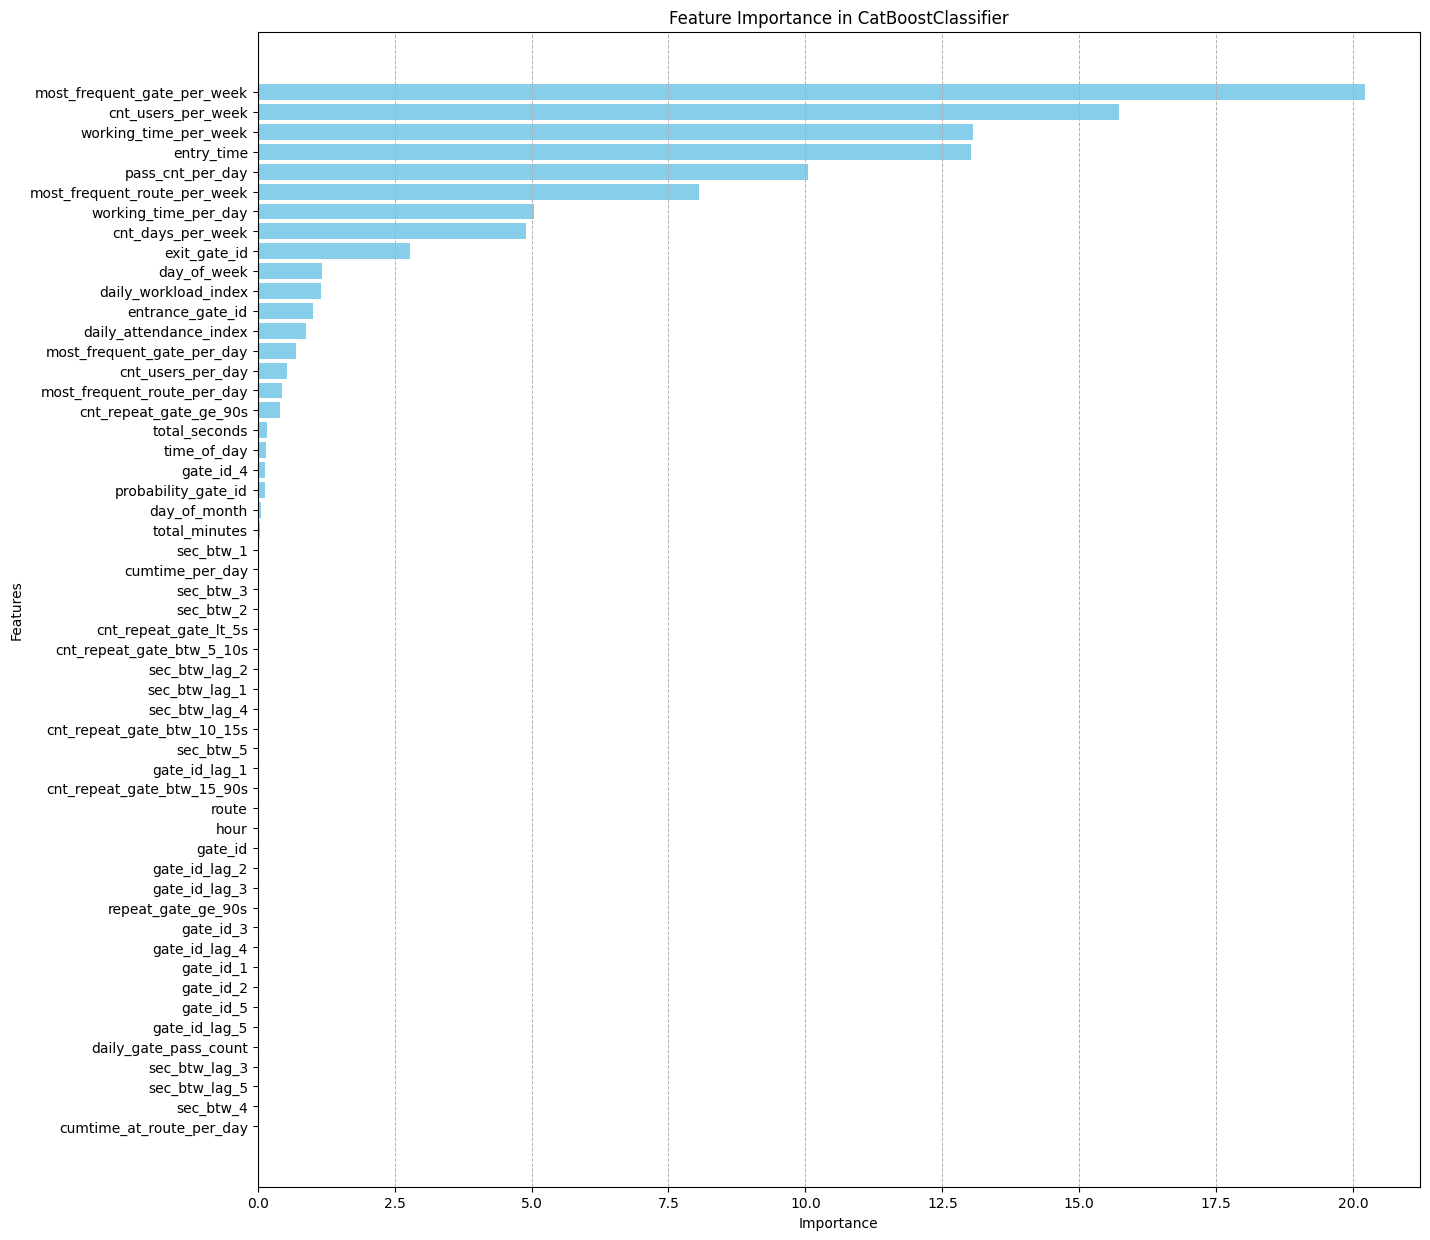

In [118]:
plt.figure(figsize=(15, 15))
plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoostClassifier')
plt.grid(axis='x', linestyle='--', linewidth=0.7)

#### SHAP values

## Итоговое предсказание лучшей модели

In [119]:
def make_prediction_dict(df_test, name_columns, model):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    result['pred_user_id'] = model.predict(X)
    result = result.groupby('user_word')['pred_user_id'].agg(lambda group: dict(group.value_counts())).to_dict()
    return result

In [165]:
def make_prediction(df_test, name_columns, model):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    result['pred_user_id'] = model.predict(X)
    # датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id для конкретной категории user_word
    temp_1 = result.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
    # датафрейм: user_word; количество user_word
    temp_2 = result['user_word'].value_counts().reset_index(name='count_user_word')
    # датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word
    result = temp_1.merge(temp_2, on='user_word', how='left')
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word
    result['confidence'] = result['count_pred_user_id_in_user_word'] / result['count_user_word']
    # сортируем данные по убыванию уверенности
    result = result.sort_values(by='confidence', ascending=False)

    # формируем итоговый датафрейм
    final = pd.DataFrame(columns=['user_word', 'preds'])
    # user_word, которые уже добавлены в final
    words = set()
    # user_id, которые уже добавлены в final
    ids = set()
    # добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
    for _, row in result.iterrows():
        word, user_id = row['user_word'], row['pred_user_id']
        if word not in words and user_id not in ids and row['confidence'] > 0.1:
            final.loc[len(final)] = [word, user_id]
            words.add(word)
            ids.add(user_id)

    # категориям, насчет которых модель не уверена, проставляется -999
    for word in (set(result['user_word'].unique()) - set(final['user_word'])):
        final.loc[len(final)] = [word, -999]
    
    return final.sort_values(by='user_word')

In [147]:
df_test = df_test.rename(columns={'user_id': 'user_word'})

Вариант Ивана

In [148]:
# выбор ответа для конкретного user_word
def choosing_answer(votes):
    votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)
    
    if len(votes) == 1:                 # если существует единственный вариант ответа
        return votes[0]                 # возвращаем ответ и число голосов
    if votes[0][1] == votes[1][1]:      # если первые два места равны
        return -999, 100                # ответ со 100% неопределен
    return votes[0]


# функция отбора голосов
def vote_processing(d):
    word_to_id = {}
    id_to_word = {}
    result = []

    for user_word, votes in d.items():
        user_id, num = choosing_answer(votes)           # получили ответ и количество голосов
        result.append(tuple([user_word, user_id, num]))

    # отсортируем список по уверенности в ответе
    result = sorted(result, key=lambda x: x[2], reverse=True)

    # проверим список на наличие дубликатов:
    for user_word, user_id, number_of_votes in result:
        # ситуация, когда ответ user_id неопознан или уже есть (и его приоритет ниже, так как список отсортирован по убыванию уверенности)
        if user_id == -999 or user_id in id_to_word:
            word_to_id[user_word] = -999
            continue
        word_to_id[user_word] = user_id
        id_to_word[user_id] = user_word

    # сохраним в требуемом формате
    df = pd.Series(word_to_id).to_frame().reset_index()
    df.columns = ['user_word', 'preds']
    df = df.groupby('user_word')['preds'].first().to_frame()
    return df

Загрузим сохраненную ранее лучшую модель `CatBoostClassifier`

In [149]:
model_cb = CatBoostClassifier()
model_cb.load_model('../models/model_cb_v_02.cbm')

Сделаем предсказание

In [150]:
result_dct = make_prediction_dict(df_test, X.columns, model_cb)
result_dct

{'aucroc': {49: 14, 24: 13},
 'binary': {12: 170, 14: 33, 46: 21, 9: 12},
 'blue': {56: 5, 14: 3},
 'categorical': {14: 124},
 'coefficient': {1: 14, 3: 13, 22: 7, 14: 5, 15: 2},
 'collinear': {32: 61,
  19: 34,
  54: 24,
  1: 20,
  6: 9,
  35: 9,
  46: 5,
  12: 5,
  17: 4,
  25: 4,
  33: 3,
  11: 3,
  50: 3,
  49: 2,
  0: 2,
  55: 1},
 'distributed': {35: 28, 11: 26, 39: 10, 19: 10, 33: 5, 0: 2},
 'epsilon': {1: 192, 26: 22, 49: 6},
 'f1': {6: 350, 37: 98, 33: 8},
 'fit': {17: 27,
  23: 25,
  47: 23,
  11: 13,
  15: 11,
  3: 11,
  37: 10,
  43: 6,
  0: 5,
  46: 3},
 'gini': {15: 107, 39: 16, 49: 6, 7: 6, 3: 4},
 'independent': {1: 49, 49: 35, 15: 29, 14: 25, 39: 23, 33: 10, 9: 4},
 'lasso': {56: 7, 11: 7, 25: 3, 23: 3},
 'linear': {17: 93, 18: 25, 32: 6, 3: 6, 33: 6, 50: 4, 0: 2},
 'logistic': {56: 3},
 'loss': {19: 83,
  15: 81,
  12: 35,
  35: 28,
  53: 23,
  49: 20,
  11: 16,
  39: 13,
  55: 10},
 'matrix': {32: 30, 46: 26, 48: 14, 54: 12, 15: 6, 23: 5},
 'minimization': {50: 32, 4

In [167]:
make_prediction_dict(df_test, X.columns, ctbst_only_train)

{'aucroc': {24: 27},
 'binary': {12: 161, 14: 33, 9: 15, 46: 12, 55: 11, 43: 4},
 'blue': {56: 5, 14: 3},
 'categorical': {14: 115, 56: 8, 39: 1},
 'coefficient': {3: 15, 39: 9, 22: 7, 1: 5, 24: 5},
 'collinear': {32: 48,
  35: 22,
  19: 21,
  54: 19,
  46: 18,
  11: 14,
  48: 13,
  55: 12,
  6: 9,
  12: 5,
  17: 4,
  33: 3,
  50: 1},
 'distributed': {0: 28, 35: 25, 39: 10, 19: 10, 33: 8},
 'epsilon': {1: 155, 26: 34, 49: 31},
 'f1': {6: 358, 37: 98},
 'fit': {17: 30, 47: 24, 23: 23, 15: 17, 11: 13, 3: 11, 0: 9, 43: 4, 46: 3},
 'gini': {15: 99, 39: 23, 49: 6, 7: 6, 3: 5},
 'independent': {39: 55, 49: 42, 15: 28, 14: 25, 1: 21, 9: 4},
 'lasso': {56: 10, 39: 7, 23: 3},
 'linear': {17: 51, 0: 23, 23: 21, 18: 20, 33: 11, 35: 9, 50: 5, 3: 2},
 'logistic': {56: 3},
 'loss': {19: 118,
  15: 61,
  11: 29,
  12: 22,
  35: 20,
  49: 20,
  55: 18,
  9: 18,
  47: 3},
 'matrix': {32: 20, 54: 19, 46: 14, 0: 10, 48: 8, 11: 7, 29: 6, 23: 5, 15: 4},
 'minimization': {46: 23, 29: 19, 50: 13, 33: 9, 56: 

In [178]:
make_prediction_dict(df_test, X.columns, ctbst_all)

{'aucroc': {49: 14, 24: 13},
 'binary': {12: 176, 14: 33, 46: 21, 9: 6},
 'blue': {56: 5, 14: 3},
 'categorical': {14: 124},
 'coefficient': {3: 15, 1: 14, 22: 7, 14: 5},
 'collinear': {32: 61,
  54: 27,
  1: 18,
  19: 16,
  43: 10,
  49: 10,
  6: 9,
  35: 9,
  46: 7,
  12: 5,
  17: 4,
  25: 4,
  33: 3,
  11: 3,
  0: 2,
  55: 1},
 'distributed': {35: 33, 11: 28, 39: 10, 19: 10},
 'epsilon': {1: 190, 26: 22, 49: 8},
 'f1': {6: 358, 37: 90, 33: 8},
 'fit': {17: 30,
  23: 25,
  47: 24,
  11: 13,
  15: 10,
  37: 10,
  3: 8,
  43: 6,
  0: 5,
  46: 3},
 'gini': {15: 100, 39: 23, 49: 6, 7: 6, 3: 4},
 'independent': {1: 49, 49: 35, 15: 29, 14: 25, 39: 24, 33: 9, 9: 4},
 'lasso': {56: 7, 11: 7, 25: 3, 23: 3},
 'linear': {17: 95, 18: 25, 33: 8, 32: 6, 3: 6, 50: 2},
 'logistic': {56: 3},
 'loss': {19: 86,
  15: 81,
  35: 30,
  12: 26,
  49: 20,
  11: 18,
  55: 17,
  39: 17,
  53: 14},
 'matrix': {32: 28, 46: 25, 48: 14, 54: 12, 15: 6, 23: 3, 0: 2, 40: 2, 25: 1},
 'minimization': {50: 29, 46: 19, 

In [151]:
vote_processing(result_dct)

,preds
user_word,
aucroc,49
binary,12
blue,56
categorical,14
coefficient,-999
collinear,-999
distributed,35
epsilon,1
f1,6


In [152]:
result_cb = make_prediction(df_test, X.columns, model_cb)
result_cb

,user_word,preds
14,aucroc,49
8,binary,12
29,blue,-999
1,categorical,14
23,coefficient,22
30,collinear,-999
20,distributed,35
5,epsilon,1
7,f1,6
22,fit,23


In [153]:
len(result_cb)

34

In [169]:
res = make_prediction(df_test, X.columns, ctbst_only_train)
res

,user_word,preds
0,aucroc,24
8,binary,12
30,blue,-999
4,categorical,14
25,coefficient,22
31,collinear,-999
19,distributed,0
7,epsilon,1
5,f1,6
24,fit,47


In [179]:
res_all = make_prediction(df_test, X.columns, ctbst_all)
res_all

,user_word,preds
13,aucroc,49
7,binary,12
29,blue,-999
0,categorical,14
24,coefficient,22
30,collinear,-999
17,distributed,35
5,epsilon,1
6,f1,6
23,fit,23


Сохраненим результаты

In [154]:
csv_buffer = io.StringIO()
result_cb.to_csv(csv_buffer, index=False)
with zipfile.ZipFile('../data/answer.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.writestr('answer.csv', csv_buffer.getvalue())

In [155]:
result_cb.to_csv('../data/submit_cb_v_02.csv', index=False)

In [170]:
res.to_csv('../data/submit_cb_v_0_.csv', index=False)

In [180]:
res_all.to_csv('../data/submit_cb_v_0_all.csv', index=False)

# Сравнение ответов

In [181]:
right_answers = pd.read_csv(r'E:\projects\SHIFT\предыдущие_наработки\right_answers.csv')
res_ivan = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\1) 04_02_2024\answer_ivan.csv')
res_vera = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\4) Ivanova_Vera_SaintPetersburg 358\shift_ml-main\answer_vera.csv')
res_cb_01 = pd.read_csv('../data/submit_cb_v_01_264.csv')
res_cb_02 = pd.read_csv('../data/submit_cb_v_02.csv')
res_cb_0_ = pd.read_csv('../data/submit_cb_v_0_.csv')
res_cb_0_all = pd.read_csv('../data/submit_cb_v_0_all.csv')

In [182]:
res = right_answers.loc[:].rename(columns={'preds': 'right_answers'})
res['right_answers'] = res['right_answers'].apply(lambda x: f'{x:.0f}')
res['ivan'] = res_ivan['preds']
res['vera'] = res_vera['preds']
res['cb_v_01_264'] = res_cb_01['preds']
res['cb_v_02'] = res_cb_02['preds']
res['cb_v_0_'] = res_cb_0_['preds']
res['cb_v_0_all'] = res_cb_0_all['preds']

In [183]:
# Функция для условного форматирования
def highlight_matching_cells(x):
    ref_col = x['vera']
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for col in x.columns:
        if col == 'right_answers':
            df_styled[col] = ['background-color: red' if x[col].iloc[i] != 'nan' else '' for i in range(len(x))]
        elif col != 'vera':
            df_styled[col] = ['background-color: green' if x[col].iloc[i] == ref_col.iloc[i] else '' for i in range(len(x))]
    return df_styled

# Применение стиля
res.style.apply(highlight_matching_cells, axis=None)

,user_word,right_answers,ivan,vera,cb_v_01_264,cb_v_02,cb_v_0_,cb_v_0_all
0,aucroc,24,24,24,24,49,24,49
1,binary,12,12,12,12,12,12,12
2,blue,nan,-999,56,-999,-999,-999,-999
3,categorical,14,14,14,14,14,14,14
4,coefficient,nan,-999,27,22,22,22,22
5,collinear,nan,-999,23,-999,-999,-999,-999
6,distributed,0,0,0,0,35,0,35
7,epsilon,1,1,1,1,1,1,1
8,f1,6,6,18,37,6,6,6
9,fit,nan,23,6,-999,23,47,23


# The end